In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

cols = ['n_severe', 'n_critical', 'cum_deaths']
n_runs = 3
n_trials = 1000

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


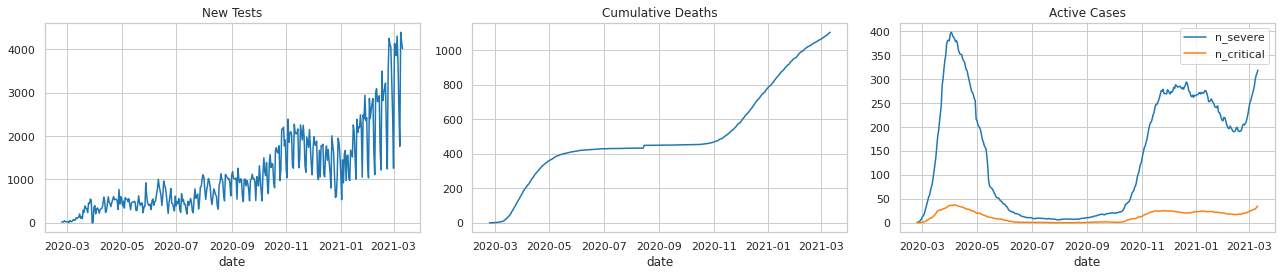

In [2]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)

_, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[2]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[2]).set(ylabel='')

plt.tight_layout()

In [3]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

In [4]:
import optuna as op
from util.interventions import get_interventions

def unused_param(trial, name, value=0.):
    return trial.suggest_float(name, value, value)

def objective(trial):
    # define learnable parameters
    initial_params = dict(
        pop_infected=trial.suggest_int('init_pop_infected', 3029, 4252, step=1),
        n_imports=trial.suggest_float('init_n_imports', 2.0, 2.5, step=1e-1),
        beta=trial.suggest_float('init_beta', 0.025, 0.029, step=1e-3),
        rel_symp_prob=trial.suggest_float('init_rel_symp_prob', 5.05, 8.04, log=True),
        rel_severe_prob=trial.suggest_float('init_rel_severe_prob', 0.07, 0.11, log=True),
        rel_crit_prob=trial.suggest_float('init_rel_crit_prob', 0.96, 1.18, log=True),
        rel_death_prob=trial.suggest_float('init_rel_death_prob', 6.17, 7.77, log=True),
        **default_params
    )
    intervention_params = dict(
        trace_prob=trial.suggest_float('interv_trace_prob', 0.41, 0.56, step=1e-2),           # CONTACT TRACING
        trace_time=trial.suggest_float('interv_trace_time', 3.2, 5.2, step=1e-1),           #
        work_contacts=trial.suggest_float('interv_work_contacts', 0.57, 0.65, step=1e-2),     # SMART WORKING
        school_contacts=trial.suggest_float('interv_school_contacts', 0.25, 0.48, step=1e-2), # SCHOOLS CLOSED
        yellow_contacts=trial.suggest_float('interv_yellow_contacts', 0.4, 1.0, step=1e-2),                      # LOCKDOWN INTERACTIONS
        orange_contacts=trial.suggest_float('interv_orange_contacts', 0.2, 0.9, step=1e-2),                      #
        summer_imports=trial.suggest_float('interv_summer_imp', 2.1, 11.4, step=1e-1),                            # IMPORTED CASES
        yellow_imports=trial.suggest_float('interv_yellow_imp', 0.0, 12.0, step=1e-1),                            #
        orange_imports=trial.suggest_float('interv_orange_imp', 0.0, 8.0, step=1e-1),                            #
        summer_beta=trial.suggest_float('interv_summer_beta', 0.101, 0.197, step=1e-3),                              # VIRAL LOAD REDUCTION
        winter_beta=trial.suggest_float('interv_winter_beta', 0.0, 0.2, step=1e-3),                              #
        summer_symp=trial.suggest_float('interv_summer_symp', 0.0123, 0.031, log=True),                              #
        winter_symp=trial.suggest_float('interv_winter_symp', 0.01, 10.0, log=True),                              #
        summer_sev=trial.suggest_float('interv_summer_sev', 0.01, 0.018, log=True),                                #
        winter_sev=trial.suggest_float('interv_winter_sev', 0.01, 10.0, log=True),                               #
        summer_crit=trial.suggest_float('interv_summer_crit', 0.48, 1.76, log=True),                              #
        winter_crit=trial.suggest_float('interv_winter_crit', 0.01, 10.0, log=True),                              #
        summer_death=trial.suggest_float('interv_summer_death', 0.075, 6.442, log=True),                            #
        winter_death=trial.suggest_float('interv_winter_death', 0.01, 10.0, log=True),                            #
    )
    # define and run simulations
    sim = cv.Sim(pars=initial_params, interventions=get_interventions(intervention_params), datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    # compute loss
    mismatches = [s.compute_fit(keys=cols, weights={c: 1 for c in cols}).mismatch for s in msim.sims]
    return sum(mismatches) / n_runs

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-11 20:18:02,206] A new study created in memory with name: no-name-022e2ee3-dac0-443c-b207-64b949a24661
[I 2021-03-11 20:18:17,131] Trial 0 finished with value: 272.4939026273998 and parameters: {'init_pop_infected': 4156, 'init_n_imports': 2.4, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 6.406820536126331, 'init_rel_severe_prob': 0.08548969495340294, 'init_rel_crit_prob': 1.1498947300917997, 'init_rel_death_prob': 7.080737128214372, 'interv_trace_prob': 0.5, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.41000000000000003, 'interv_orange_contacts': 0.8300000000000001, 'interv_summer_imp': 7.1, 'interv_yellow_imp': 8.8, 'interv_orange_imp': 4.1000000000000005, 'interv_summer_beta': 0.177, 'interv_winter_beta': 0.182, 'interv_summer_symp': 0.015455741652400448, 'interv_winter_symp': 0.14984477164530483, 'interv_summer_sev': 0.012137650041106932, 'interv_winter_sev': 0

[I 2021-03-11 20:20:02,493] Trial 8 finished with value: 268.2597578698606 and parameters: {'init_pop_infected': 4095, 'init_n_imports': 2.1, 'init_beta': 0.025, 'init_rel_symp_prob': 6.6627056821487605, 'init_rel_severe_prob': 0.09675517846104917, 'init_rel_crit_prob': 0.9655426621817121, 'init_rel_death_prob': 6.426569895603878, 'interv_trace_prob': 0.41, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.62, 'interv_orange_contacts': 0.42000000000000004, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 12.0, 'interv_orange_imp': 6.9, 'interv_summer_beta': 0.12100000000000001, 'interv_winter_beta': 0.136, 'interv_summer_symp': 0.023895632313730507, 'interv_winter_symp': 3.0107741898716918, 'interv_summer_sev': 0.016477196686275827, 'interv_winter_sev': 2.4375706194466433, 'interv_summer_crit': 0.6509332657950322, 'interv_winter_crit': 0.0732085679251291, 'interv_summer_death': 0.3142657744469993, 'interv_wi

[I 2021-03-11 20:21:46,398] Trial 16 finished with value: 284.10405782943855 and parameters: {'init_pop_infected': 3816, 'init_n_imports': 2.0, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 6.47547163714634, 'init_rel_severe_prob': 0.10334326552271883, 'init_rel_crit_prob': 1.0348361536176642, 'init_rel_death_prob': 7.235136175033198, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.98, 'interv_orange_contacts': 0.51, 'interv_summer_imp': 11.3, 'interv_yellow_imp': 3.8000000000000003, 'interv_orange_imp': 2.7, 'interv_summer_beta': 0.158, 'interv_winter_beta': 0.125, 'interv_summer_symp': 0.02433466575649772, 'interv_winter_symp': 0.010627505422659667, 'interv_summer_sev': 0.015264824791417931, 'interv_winter_sev': 0.39830529777627727, 'interv_summer_crit': 1.5208674508499893, 'interv_winter_crit': 0.7383218869444486, 'interv_summer_death': 0.38787752940660314, 'interv

[I 2021-03-11 20:23:30,716] Trial 24 finished with value: 286.94160031117696 and parameters: {'init_pop_infected': 3457, 'init_n_imports': 2.2, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.603192252504654, 'init_rel_severe_prob': 0.10278248124710392, 'init_rel_crit_prob': 1.1037883534358277, 'init_rel_death_prob': 6.20152712580851, 'interv_trace_prob': 0.48, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.5900000000000001, 'interv_orange_contacts': 0.56, 'interv_summer_imp': 6.0, 'interv_yellow_imp': 4.6000000000000005, 'interv_orange_imp': 5.1000000000000005, 'interv_summer_beta': 0.10200000000000001, 'interv_winter_beta': 0.074, 'interv_summer_symp': 0.01691789296660863, 'interv_winter_symp': 1.387906639431616, 'interv_summer_sev': 0.01378032134450677, 'interv_winter_sev': 0.7766816696601347, 'interv_summer_crit': 0.7749176730796306, 'interv_winter_crit': 0.019349595548576667, 'interv_summe

[I 2021-03-11 20:25:17,402] Trial 32 finished with value: 273.6861183101794 and parameters: {'init_pop_infected': 3514, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.351771355138497, 'init_rel_severe_prob': 0.075330205071351, 'init_rel_crit_prob': 1.142753929710371, 'init_rel_death_prob': 7.367691441462983, 'interv_trace_prob': 0.42, 'interv_trace_time': 3.8000000000000003, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.75, 'interv_orange_contacts': 0.4, 'interv_summer_imp': 5.9, 'interv_yellow_imp': 8.3, 'interv_orange_imp': 5.5, 'interv_summer_beta': 0.179, 'interv_winter_beta': 0.029, 'interv_summer_symp': 0.018838304829511748, 'interv_winter_symp': 9.87433556197748, 'interv_summer_sev': 0.012447844327156773, 'interv_winter_sev': 0.01259306102388817, 'interv_summer_crit': 0.4814895010719682, 'interv_winter_crit': 1.852599557385219, 'interv_summer_death': 0.949828959716076, 'in

[I 2021-03-11 20:27:02,727] Trial 40 finished with value: 285.2473915395387 and parameters: {'init_pop_infected': 3492, 'init_n_imports': 2.1, 'init_beta': 0.028, 'init_rel_symp_prob': 5.3394797894606825, 'init_rel_severe_prob': 0.09115575833523093, 'init_rel_crit_prob': 1.1398611668417136, 'init_rel_death_prob': 6.973635788833511, 'interv_trace_prob': 0.49, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.72, 'interv_orange_contacts': 0.8700000000000001, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 6.300000000000001, 'interv_orange_imp': 4.4, 'interv_summer_beta': 0.15300000000000002, 'interv_winter_beta': 0.136, 'interv_summer_symp': 0.02261160655559296, 'interv_winter_symp': 1.451213239128532, 'interv_summer_sev': 0.012208817233455942, 'interv_winter_sev': 0.01755410764382767, 'interv_summer_crit': 0.5612545470289189, 'interv_winter_crit': 0.059231474041122494, 'interv_summer_death': 0.

[I 2021-03-11 20:28:47,250] Trial 48 finished with value: 279.3121994616876 and parameters: {'init_pop_infected': 3627, 'init_n_imports': 2.2, 'init_beta': 0.028, 'init_rel_symp_prob': 6.104494785982025, 'init_rel_severe_prob': 0.0968055562591847, 'init_rel_crit_prob': 1.1286144430456435, 'init_rel_death_prob': 6.484434247056682, 'interv_trace_prob': 0.47, 'interv_trace_time': 4.300000000000001, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.8500000000000001, 'interv_orange_contacts': 0.28, 'interv_summer_imp': 5.5, 'interv_yellow_imp': 3.4000000000000004, 'interv_orange_imp': 2.9000000000000004, 'interv_summer_beta': 0.197, 'interv_winter_beta': 0.019, 'interv_summer_symp': 0.014852075270564272, 'interv_winter_symp': 1.294490637097018, 'interv_summer_sev': 0.010543986594881857, 'interv_winter_sev': 1.0082929501749869, 'interv_summer_crit': 0.6567579716402665, 'interv_winter_crit': 0.05980264987600751, 'interv_summer_death': 2.529097712630294,

[I 2021-03-11 20:30:29,760] Trial 56 finished with value: 300.66168196946836 and parameters: {'init_pop_infected': 3151, 'init_n_imports': 2.1, 'init_beta': 0.028, 'init_rel_symp_prob': 7.212654952351672, 'init_rel_severe_prob': 0.10965829719334634, 'init_rel_crit_prob': 1.1245626293388822, 'init_rel_death_prob': 6.821242558379866, 'interv_trace_prob': 0.43999999999999995, 'interv_trace_time': 3.3000000000000003, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.79, 'interv_orange_contacts': 0.48000000000000004, 'interv_summer_imp': 5.1, 'interv_yellow_imp': 8.3, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.12200000000000001, 'interv_winter_beta': 0.17, 'interv_summer_symp': 0.028308641604830223, 'interv_winter_symp': 0.4813383508953345, 'interv_summer_sev': 0.012460005371667636, 'interv_winter_sev': 0.9747255041633038, 'interv_summer_crit': 0.706251222568877, 'interv_winter_crit': 0.02998315156115825, 'interv_summer_death': 2.

[I 2021-03-11 20:32:12,116] Trial 64 finished with value: 275.80049548728414 and parameters: {'init_pop_infected': 3391, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.535715324608414, 'init_rel_severe_prob': 0.08645859391323774, 'init_rel_crit_prob': 1.1096364215266745, 'init_rel_death_prob': 6.760580378259647, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 4.2, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 9.200000000000001, 'interv_yellow_imp': 10.200000000000001, 'interv_orange_imp': 5.7, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.17400000000000002, 'interv_summer_symp': 0.021452532823918173, 'interv_winter_symp': 0.23622850881008176, 'interv_summer_sev': 0.0173151040810239, 'interv_winter_sev': 0.036895403163360846, 'interv_summer_crit': 0.8596121609982542, 'interv_winter_crit': 0.2496933966930

[I 2021-03-11 20:33:54,307] Trial 72 finished with value: 266.6728743655038 and parameters: {'init_pop_infected': 3544, 'init_n_imports': 2.2, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.4679070947172645, 'init_rel_severe_prob': 0.08249159131867563, 'init_rel_crit_prob': 1.0816063707674834, 'init_rel_death_prob': 7.0609071630296105, 'interv_trace_prob': 0.48, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.41000000000000003, 'interv_summer_imp': 7.5, 'interv_yellow_imp': 11.0, 'interv_orange_imp': 6.2, 'interv_summer_beta': 0.114, 'interv_winter_beta': 0.001, 'interv_summer_symp': 0.01991125555443707, 'interv_winter_symp': 0.3827118866139474, 'interv_summer_sev': 0.015442629707622606, 'interv_winter_sev': 0.05163738075530715, 'interv_summer_crit': 0.6309581322732793, 'interv_winter_crit': 0.09422437827824856, 'interv_summer_death': 0.9564196006

[I 2021-03-11 20:35:37,342] Trial 80 finished with value: 267.6323604789772 and parameters: {'init_pop_infected': 3610, 'init_n_imports': 2.1, 'init_beta': 0.025, 'init_rel_symp_prob': 5.128219067212652, 'init_rel_severe_prob': 0.08879703579590643, 'init_rel_crit_prob': 0.9937062866076132, 'init_rel_death_prob': 7.102891980294187, 'interv_trace_prob': 0.5, 'interv_trace_time': 4.6000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.9600000000000001, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 7.300000000000001, 'interv_yellow_imp': 10.8, 'interv_orange_imp': 0.30000000000000004, 'interv_summer_beta': 0.175, 'interv_winter_beta': 0.097, 'interv_summer_symp': 0.019884484090811803, 'interv_winter_symp': 0.019575504105940503, 'interv_summer_sev': 0.016600198237270467, 'interv_winter_sev': 0.013022367729027394, 'interv_summer_crit': 0.540241951827955, 'interv_winter_crit': 0.1779164747448016, 'interv_summer_death':

[I 2021-03-11 20:37:19,567] Trial 88 finished with value: 280.30229026832785 and parameters: {'init_pop_infected': 3741, 'init_n_imports': 2.1, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.051792250857806, 'init_rel_severe_prob': 0.08241403429841677, 'init_rel_crit_prob': 1.0245983370953649, 'init_rel_death_prob': 7.154599801091017, 'interv_trace_prob': 0.49, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.8400000000000001, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.700000000000001, 'interv_yellow_imp': 10.600000000000001, 'interv_orange_imp': 7.4, 'interv_summer_beta': 0.176, 'interv_winter_beta': 0.123, 'interv_summer_symp': 0.019559857372552322, 'interv_winter_symp': 0.14698026517028653, 'interv_summer_sev': 0.015426653106237786, 'interv_winter_sev': 0.01967759931639867, 'interv_summer_crit': 0.5258455036238406, 'interv_winter_crit': 0.20079272520823765, 'interv_summer_death':

[I 2021-03-11 20:39:01,777] Trial 96 finished with value: 273.22069909629676 and parameters: {'init_pop_infected': 3800, 'init_n_imports': 2.4, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.270827825188521, 'init_rel_severe_prob': 0.09213866183382922, 'init_rel_crit_prob': 1.0804801214068132, 'init_rel_death_prob': 7.713146285711396, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.78, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 6.6, 'interv_yellow_imp': 0.7000000000000001, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.169, 'interv_summer_symp': 0.021192232719924507, 'interv_winter_symp': 0.6219610680675469, 'interv_summer_sev': 0.015266672017819193, 'interv_winter_sev': 0.04505953538502578, 'interv_summer_crit': 0.6711505628341669, 'interv_winter_crit': 0.12391276490710647, 'interv_summer_death': 0.728294060015

[I 2021-03-11 20:40:43,913] Trial 104 finished with value: 271.67339654728875 and parameters: {'init_pop_infected': 3540, 'init_n_imports': 2.4, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.254748154201629, 'init_rel_severe_prob': 0.09443800826852906, 'init_rel_crit_prob': 1.0732829519918066, 'init_rel_death_prob': 7.100259582142833, 'interv_trace_prob': 0.51, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.69, 'interv_orange_contacts': 0.31, 'interv_summer_imp': 8.0, 'interv_yellow_imp': 0.6000000000000001, 'interv_orange_imp': 0.9, 'interv_summer_beta': 0.154, 'interv_winter_beta': 0.151, 'interv_summer_symp': 0.018014011176381774, 'interv_winter_symp': 0.5922553591177886, 'interv_summer_sev': 0.01338257664129815, 'interv_winter_sev': 0.07154974449404806, 'interv_summer_crit': 0.6149226351268736, 'interv_winter_crit': 0.07044478536706568, 'interv_summer_death': 0.9635372373590418, 'interv_w

[I 2021-03-11 20:42:25,935] Trial 112 finished with value: 263.8011067522441 and parameters: {'init_pop_infected': 3651, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.378289553900285, 'init_rel_severe_prob': 0.08316646501619052, 'init_rel_crit_prob': 1.090541004676824, 'init_rel_death_prob': 6.87884005851123, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.300000000000001, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.4, 'interv_summer_imp': 8.200000000000001, 'interv_yellow_imp': 2.1, 'interv_orange_imp': 2.9000000000000004, 'interv_summer_beta': 0.14400000000000002, 'interv_winter_beta': 0.17400000000000002, 'interv_summer_symp': 0.01603520839787658, 'interv_winter_symp': 0.2721696942719754, 'interv_summer_sev': 0.01502615961786491, 'interv_winter_sev': 0.04043432536126905, 'interv_summer_crit': 1.1179849223414369, 'interv_winter_crit': 0.1000

[I 2021-03-11 20:44:07,688] Trial 120 finished with value: 272.5584842225972 and parameters: {'init_pop_infected': 3656, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.481287211848113, 'init_rel_severe_prob': 0.08408543900738064, 'init_rel_crit_prob': 1.0943414831571234, 'init_rel_death_prob': 6.888406338499553, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.1, 'interv_yellow_imp': 2.9000000000000004, 'interv_orange_imp': 2.8000000000000003, 'interv_summer_beta': 0.14500000000000002, 'interv_winter_beta': 0.157, 'interv_summer_symp': 0.014348870188190211, 'interv_winter_symp': 1.079722657495697, 'interv_summer_sev': 0.015853119970133618, 'interv_winter_sev': 0.08104443667468, 'interv_summer_crit': 1.0523988282983372, 'interv_winter_crit': 0.193143861814541, 'interv_summer_death': 1.5765

[I 2021-03-11 20:45:49,174] Trial 128 finished with value: 270.1575611861411 and parameters: {'init_pop_infected': 3658, 'init_n_imports': 2.2, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.374187274042474, 'init_rel_severe_prob': 0.08559426613685775, 'init_rel_crit_prob': 1.07854090685991, 'init_rel_death_prob': 6.833138204216689, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.300000000000001, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.76, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 7.1, 'interv_yellow_imp': 1.6, 'interv_orange_imp': 3.0, 'interv_summer_beta': 0.138, 'interv_winter_beta': 0.149, 'interv_summer_symp': 0.015253142131212717, 'interv_winter_symp': 0.35259803556247094, 'interv_summer_sev': 0.014752321457952654, 'interv_winter_sev': 0.04855098317049422, 'interv_summer_crit': 1.1668682376988124, 'interv_winter_crit': 0.9729677857544138, 'interv_summer_death': 1.42208648876056

[I 2021-03-11 20:47:31,074] Trial 136 finished with value: 291.2059854802692 and parameters: {'init_pop_infected': 3612, 'init_n_imports': 2.2, 'init_beta': 0.029, 'init_rel_symp_prob': 5.3320372320913485, 'init_rel_severe_prob': 0.08951836028642478, 'init_rel_crit_prob': 1.0927820554612324, 'init_rel_death_prob': 7.0811833738929835, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.8600000000000001, 'interv_orange_contacts': 0.37, 'interv_summer_imp': 8.200000000000001, 'interv_yellow_imp': 8.0, 'interv_orange_imp': 6.0, 'interv_summer_beta': 0.131, 'interv_winter_beta': 0.163, 'interv_summer_symp': 0.016187330929983097, 'interv_winter_symp': 0.2826474794520566, 'interv_summer_sev': 0.01614542560834583, 'interv_winter_sev': 0.07567728563973106, 'interv_summer_crit': 0.9345812679865221, 'interv_winter_crit': 0.4937835721586718, 'interv_summer_death': 0.58904887623162

[I 2021-03-11 20:49:12,624] Trial 144 finished with value: 274.1626941730106 and parameters: {'init_pop_infected': 3694, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.447525050553506, 'init_rel_severe_prob': 0.0911611882184147, 'init_rel_crit_prob': 1.0952872363463397, 'init_rel_death_prob': 7.172248209948645, 'interv_trace_prob': 0.47, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.47, 'interv_yellow_contacts': 0.8, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 8.6, 'interv_yellow_imp': 1.0, 'interv_orange_imp': 1.2000000000000002, 'interv_summer_beta': 0.158, 'interv_winter_beta': 0.197, 'interv_summer_symp': 0.017012472378214814, 'interv_winter_symp': 0.11294044258297668, 'interv_summer_sev': 0.015403078242441328, 'interv_winter_sev': 0.031709825792000504, 'interv_summer_crit': 1.2914904156308646, 'interv_winter_crit': 0.16645774405374847, 'interv_summer_death': 1.70043305912

[I 2021-03-11 20:50:54,658] Trial 152 finished with value: 283.38316952237426 and parameters: {'init_pop_infected': 3491, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.45416935961305, 'init_rel_severe_prob': 0.07084981959798489, 'init_rel_crit_prob': 1.1149836090838945, 'init_rel_death_prob': 7.197183280023446, 'interv_trace_prob': 0.49, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.76, 'interv_orange_contacts': 0.43000000000000005, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 1.6, 'interv_orange_imp': 6.1000000000000005, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.168, 'interv_summer_symp': 0.01911803833698436, 'interv_winter_symp': 2.050208210777537, 'interv_summer_sev': 0.017311898635182527, 'interv_winter_sev': 0.02667129887126324, 'interv_summer_crit': 1.0949649261552181, 'interv_winter_crit': 0.10384711038671449, 'interv_summer_death': 1

[I 2021-03-11 20:52:37,265] Trial 160 finished with value: 277.25522237963327 and parameters: {'init_pop_infected': 3308, 'init_n_imports': 2.4, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.303217945751484, 'init_rel_severe_prob': 0.08144182040146274, 'init_rel_crit_prob': 1.0902284106627282, 'init_rel_death_prob': 6.931079834908179, 'interv_trace_prob': 0.41, 'interv_trace_time': 4.2, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.67, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.9, 'interv_yellow_imp': 7.4, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.11000000000000001, 'interv_winter_beta': 0.154, 'interv_summer_symp': 0.0149917019081796, 'interv_winter_symp': 1.1721499414374907, 'interv_summer_sev': 0.015095448600916673, 'interv_winter_sev': 0.050638317091815994, 'interv_summer_crit': 1.2476514685445539, 'interv_winter_crit': 0.13234317632083575, 'interv_summer_death': 1.1295432449755052, 'interv_w

[I 2021-03-11 20:54:19,762] Trial 168 finished with value: 272.5367536322903 and parameters: {'init_pop_infected': 3686, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 6.493385702506664, 'init_rel_severe_prob': 0.08576527360958076, 'init_rel_crit_prob': 1.085712928175411, 'init_rel_death_prob': 6.869863393971028, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.76, 'interv_orange_contacts': 0.44, 'interv_summer_imp': 6.200000000000001, 'interv_yellow_imp': 5.6000000000000005, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.128, 'interv_winter_beta': 0.074, 'interv_summer_symp': 0.017058862104891624, 'interv_winter_symp': 0.4742991990297292, 'interv_summer_sev': 0.0155162347032789, 'interv_winter_sev': 0.055868285177982, 'interv_summer_crit': 0.7070547048478846, 'interv_winter_crit': 1.4752550866711867, 'interv_summer_death': 1.239136854150878, 'i

[I 2021-03-11 20:56:02,445] Trial 176 finished with value: 275.00125663715613 and parameters: {'init_pop_infected': 3760, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.414626209980779, 'init_rel_severe_prob': 0.09180155527296598, 'init_rel_crit_prob': 1.082842533006101, 'init_rel_death_prob': 6.932080098816038, 'interv_trace_prob': 0.43999999999999995, 'interv_trace_time': 4.0, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.37, 'interv_summer_imp': 6.5, 'interv_yellow_imp': 7.800000000000001, 'interv_orange_imp': 6.5, 'interv_summer_beta': 0.113, 'interv_winter_beta': 0.105, 'interv_summer_symp': 0.01598965676429944, 'interv_winter_symp': 0.21800725180181715, 'interv_summer_sev': 0.01114144987469477, 'interv_winter_sev': 0.42173811979592396, 'interv_summer_crit': 0.6926131565548842, 'interv_winter_crit': 2.002874441708526, 'interv_summer_death': 1.681411599637227

[I 2021-03-11 20:57:44,662] Trial 184 finished with value: 270.91763522832133 and parameters: {'init_pop_infected': 3568, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.291047921597487, 'init_rel_severe_prob': 0.09277133225343621, 'init_rel_crit_prob': 1.0955868181748594, 'init_rel_death_prob': 7.1412325659223, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.77, 'interv_orange_contacts': 0.43000000000000005, 'interv_summer_imp': 8.1, 'interv_yellow_imp': 0.5, 'interv_orange_imp': 3.2, 'interv_summer_beta': 0.13, 'interv_winter_beta': 0.17500000000000002, 'interv_summer_symp': 0.021595143846691717, 'interv_winter_symp': 0.22292965439389828, 'interv_summer_sev': 0.01447184392433821, 'interv_winter_sev': 2.6392511310164606, 'interv_summer_crit': 0.7164451948630608, 'interv_winter_crit': 0.22375406177777066, 'interv_summer_death': 1.

[I 2021-03-11 20:59:26,536] Trial 192 finished with value: 281.2472309203551 and parameters: {'init_pop_infected': 3703, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.099241170492166, 'init_rel_severe_prob': 0.09068687483578274, 'init_rel_crit_prob': 1.0641860014234306, 'init_rel_death_prob': 7.077755904139309, 'interv_trace_prob': 0.42, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.42000000000000004, 'interv_yellow_contacts': 0.75, 'interv_orange_contacts': 0.47000000000000003, 'interv_summer_imp': 6.1, 'interv_yellow_imp': 5.5, 'interv_orange_imp': 0.9, 'interv_summer_beta': 0.14900000000000002, 'interv_winter_beta': 0.182, 'interv_summer_symp': 0.017639539471972162, 'interv_winter_symp': 0.5116653190244996, 'interv_summer_sev': 0.011091630854475055, 'interv_winter_sev': 1.963228216298318, 'interv_summer_crit': 0.745290236124655, 'interv_winter_crit': 1.0427590199067236, 'interv_summer_death': 1.0

[I 2021-03-11 21:01:08,265] Trial 200 finished with value: 284.99072938103745 and parameters: {'init_pop_infected': 3624, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.385014534368948, 'init_rel_severe_prob': 0.10114995643331028, 'init_rel_crit_prob': 1.0754288449188798, 'init_rel_death_prob': 6.643636113499416, 'interv_trace_prob': 0.43999999999999995, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.42000000000000004, 'interv_yellow_contacts': 0.8, 'interv_orange_contacts': 0.5, 'interv_summer_imp': 5.0, 'interv_yellow_imp': 6.0, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.15100000000000002, 'interv_winter_beta': 0.14100000000000001, 'interv_summer_symp': 0.019293621487474, 'interv_winter_symp': 1.5689646093961027, 'interv_summer_sev': 0.010889490101038296, 'interv_winter_sev': 1.8125244751593321, 'interv_summer_crit': 0.762474922565954, 'interv_winter_crit': 0.13678596341361926, 'interv_summer

[I 2021-03-11 21:02:50,774] Trial 208 finished with value: 270.5286405224408 and parameters: {'init_pop_infected': 3719, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.355913900536291, 'init_rel_severe_prob': 0.09489915520945068, 'init_rel_crit_prob': 1.0771928119463972, 'init_rel_death_prob': 6.706356618023206, 'interv_trace_prob': 0.43, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.8300000000000001, 'interv_orange_contacts': 0.45, 'interv_summer_imp': 5.800000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 6.0, 'interv_summer_beta': 0.14600000000000002, 'interv_winter_beta': 0.166, 'interv_summer_symp': 0.018155968352482666, 'interv_winter_symp': 0.36397287723743743, 'interv_summer_sev': 0.011589388353525425, 'interv_winter_sev': 0.03532517403044589, 'interv_summer_crit': 0.9073114987515535, 'interv_winter_crit': 0.184840758551

[I 2021-03-11 21:04:32,701] Trial 216 finished with value: 276.10652157440694 and parameters: {'init_pop_infected': 3646, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.259727602873168, 'init_rel_severe_prob': 0.0922017463505485, 'init_rel_crit_prob': 1.0700369277064006, 'init_rel_death_prob': 7.121281584231924, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.78, 'interv_orange_contacts': 0.35, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 2.8000000000000003, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.154, 'interv_winter_beta': 0.177, 'interv_summer_symp': 0.01769127410731891, 'interv_winter_symp': 5.479958992523107, 'interv_summer_sev': 0.011218384916121352, 'interv_winter_sev': 0.027015514311023524, 'interv_summer_crit': 1.1779730491419138, 'interv_winter_crit': 0.08168225651725242, 'interv_s

[I 2021-03-11 21:06:15,132] Trial 224 finished with value: 278.818253152551 and parameters: {'init_pop_infected': 3844, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.168275530790831, 'init_rel_severe_prob': 0.09388199717021897, 'init_rel_crit_prob': 1.095758980227301, 'init_rel_death_prob': 7.005340293519539, 'interv_trace_prob': 0.42, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.76, 'interv_orange_contacts': 0.35, 'interv_summer_imp': 5.9, 'interv_yellow_imp': 0.30000000000000004, 'interv_orange_imp': 1.1, 'interv_summer_beta': 0.188, 'interv_winter_beta': 0.161, 'interv_summer_symp': 0.018248272427989376, 'interv_winter_symp': 0.5491303556921413, 'interv_summer_sev': 0.01657736641267359, 'interv_winter_sev': 1.910642500381668, 'interv_summer_crit': 1.2773466821858774, 'interv_winter_crit': 0.16538477823345343, 'interv_summer_death': 1.465292197828467,

[I 2021-03-11 21:07:58,580] Trial 232 finished with value: 286.9824215070521 and parameters: {'init_pop_infected': 3653, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.390066593699432, 'init_rel_severe_prob': 0.07845994979130602, 'init_rel_crit_prob': 1.1151837317904694, 'init_rel_death_prob': 7.131964746206306, 'interv_trace_prob': 0.47, 'interv_trace_time': 3.7, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.45999999999999996, 'interv_yellow_contacts': 0.81, 'interv_orange_contacts': 0.5800000000000001, 'interv_summer_imp': 7.5, 'interv_yellow_imp': 1.9000000000000001, 'interv_orange_imp': 1.3, 'interv_summer_beta': 0.15200000000000002, 'interv_winter_beta': 0.181, 'interv_summer_symp': 0.018667092263693813, 'interv_winter_symp': 0.6788324145234175, 'interv_summer_sev': 0.015175859655123936, 'interv_winter_sev': 0.027791335027353863, 'interv_summer_crit': 1.104573329282355, 'interv_winter_crit': 0.11161074579387902, 'interv_

[I 2021-03-11 21:09:42,991] Trial 240 finished with value: 262.64150844595673 and parameters: {'init_pop_infected': 3974, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.388104559107805, 'init_rel_severe_prob': 0.09146112250670137, 'init_rel_crit_prob': 1.1169591746659389, 'init_rel_death_prob': 7.450423349039415, 'interv_trace_prob': 0.48, 'interv_trace_time': 4.6000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.74, 'interv_orange_contacts': 0.6100000000000001, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 2.5, 'interv_orange_imp': 0.9, 'interv_summer_beta': 0.157, 'interv_winter_beta': 0.092, 'interv_summer_symp': 0.01842169106595996, 'interv_winter_symp': 0.7319397378638588, 'interv_summer_sev': 0.014097564315699076, 'interv_winter_sev': 9.144363208062774, 'interv_summer_crit': 1.209023342812294, 'interv_winter_crit': 0.06745994527235487, 'interv_summer_death': 0.757628277523558

[I 2021-03-11 21:11:27,788] Trial 248 finished with value: 276.8243250687297 and parameters: {'init_pop_infected': 3724, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.281263706710915, 'init_rel_severe_prob': 0.08864259182968627, 'init_rel_crit_prob': 1.1188080130853388, 'init_rel_death_prob': 7.506917585682004, 'interv_trace_prob': 0.48, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.73, 'interv_orange_contacts': 0.5900000000000001, 'interv_summer_imp': 7.300000000000001, 'interv_yellow_imp': 1.8, 'interv_orange_imp': 0.9, 'interv_summer_beta': 0.164, 'interv_winter_beta': 0.097, 'interv_summer_symp': 0.017801015891319567, 'interv_winter_symp': 0.6498348591118022, 'interv_summer_sev': 0.014389123631500255, 'interv_winter_sev': 5.991444736052626, 'interv_summer_crit': 1.2984287026760046, 'interv_winter_crit': 0.0582157279279086, 'interv_summer_death': 0.8

[I 2021-03-11 21:13:12,798] Trial 256 finished with value: 275.5914066189177 and parameters: {'init_pop_infected': 3767, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.459133922806587, 'init_rel_severe_prob': 0.0931340839991029, 'init_rel_crit_prob': 1.1348861339029737, 'init_rel_death_prob': 7.605677573431668, 'interv_trace_prob': 0.48, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.75, 'interv_orange_contacts': 0.5900000000000001, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 2.2, 'interv_orange_imp': 0.7000000000000001, 'interv_summer_beta': 0.159, 'interv_winter_beta': 0.083, 'interv_summer_symp': 0.018173714718316865, 'interv_winter_symp': 0.943376370312111, 'interv_summer_sev': 0.014276603226070998, 'interv_winter_sev': 8.967068831208445, 'interv_summer_crit': 1.20804491855563, 'interv_winter_crit': 1.4694274824054052, 'interv_summer_death': 0.07854594451709959, 

[I 2021-03-11 21:14:58,028] Trial 264 finished with value: 274.04985036587965 and parameters: {'init_pop_infected': 3693, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.320072080933625, 'init_rel_severe_prob': 0.09590328346575329, 'init_rel_crit_prob': 1.1078145417667657, 'init_rel_death_prob': 7.392980245079549, 'interv_trace_prob': 0.48, 'interv_trace_time': 4.6000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.47, 'interv_yellow_contacts': 0.75, 'interv_orange_contacts': 0.35, 'interv_summer_imp': 8.200000000000001, 'interv_yellow_imp': 2.7, 'interv_orange_imp': 0.4, 'interv_summer_beta': 0.155, 'interv_winter_beta': 0.185, 'interv_summer_symp': 0.018234543062945956, 'interv_winter_symp': 0.5411626488064993, 'interv_summer_sev': 0.01085212291621303, 'interv_winter_sev': 9.67879139784018, 'interv_summer_crit': 1.3431459766789442, 'interv_winter_crit': 0.06649018891740481, 'interv_summer_death': 0.557354652019823

[I 2021-03-11 21:16:42,600] Trial 272 finished with value: 278.15130173743154 and parameters: {'init_pop_infected': 3629, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.444512090783333, 'init_rel_severe_prob': 0.09501107725797997, 'init_rel_crit_prob': 1.1000719558548004, 'init_rel_death_prob': 6.33851145713668, 'interv_trace_prob': 0.41, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.78, 'interv_orange_contacts': 0.52, 'interv_summer_imp': 6.300000000000001, 'interv_yellow_imp': 3.0, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.14200000000000002, 'interv_winter_beta': 0.185, 'interv_summer_symp': 0.01695070895678365, 'interv_winter_symp': 0.3946618570960123, 'interv_summer_sev': 0.014162385179217547, 'interv_winter_sev': 0.0473498570129908, 'interv_summer_crit': 1.1443870861916192, 'interv_winter_crit': 0.1305192654370025, 'interv_summer_death': 1.3792337972619093

[I 2021-03-11 21:18:28,920] Trial 280 finished with value: 278.6922218150185 and parameters: {'init_pop_infected': 3642, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.351893474093586, 'init_rel_severe_prob': 0.09959007380872993, 'init_rel_crit_prob': 1.1799429823036804, 'init_rel_death_prob': 6.916102552373818, 'interv_trace_prob': 0.43, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.76, 'interv_orange_contacts': 0.38, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 0.2, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.14100000000000001, 'interv_winter_beta': 0.18, 'interv_summer_symp': 0.01918639814603836, 'interv_winter_symp': 0.4810437667326628, 'interv_summer_sev': 0.014606232003988617, 'interv_winter_sev': 0.0491958323728909, 'interv_summer_crit': 0.6146234959846619, 'interv_winter_crit': 0.09599143589624827, 'interv_summer_death': 0.7095792509512107, 'interv_wint

[I 2021-03-11 21:20:13,064] Trial 288 finished with value: 281.64709846173656 and parameters: {'init_pop_infected': 3832, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.44505520648239, 'init_rel_severe_prob': 0.07966816294807474, 'init_rel_crit_prob': 1.1101136065852695, 'init_rel_death_prob': 7.037781561426936, 'interv_trace_prob': 0.48, 'interv_trace_time': 3.7, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.45, 'interv_yellow_contacts': 0.78, 'interv_orange_contacts': 0.47000000000000003, 'interv_summer_imp': 8.0, 'interv_yellow_imp': 3.0, 'interv_orange_imp': 1.0, 'interv_summer_beta': 0.16, 'interv_winter_beta': 0.193, 'interv_summer_symp': 0.013809974936220909, 'interv_winter_symp': 0.4587727901031217, 'interv_summer_sev': 0.017974709700092815, 'interv_winter_sev': 1.9092783456108653, 'interv_summer_crit': 0.4943047796889112, 'interv_winter_crit': 2.4413905430099474, 'interv_summer_death': 1.0561252455759114, 'interv_win

[I 2021-03-11 21:21:57,323] Trial 296 finished with value: 277.8152015051386 and parameters: {'init_pop_infected': 3737, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.349638107027224, 'init_rel_severe_prob': 0.08756023719156174, 'init_rel_crit_prob': 1.1084811131786874, 'init_rel_death_prob': 6.9469996547011865, 'interv_trace_prob': 0.48, 'interv_trace_time': 4.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.74, 'interv_orange_contacts': 0.35, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 7.7, 'interv_summer_beta': 0.157, 'interv_winter_beta': 0.2, 'interv_summer_symp': 0.018096375853835032, 'interv_winter_symp': 0.4860765503924383, 'interv_summer_sev': 0.014606465741925919, 'interv_winter_sev': 0.03746418375989911, 'interv_summer_crit': 1.1846829297953054, 'interv_winter_crit': 0.4417380678644031, 'interv_summer_death': 1.0052596068267654, 'interv_win

[I 2021-03-11 21:23:43,167] Trial 304 finished with value: 269.20022170886347 and parameters: {'init_pop_infected': 3661, 'init_n_imports': 2.4, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.218701224947859, 'init_rel_severe_prob': 0.09305067898603765, 'init_rel_crit_prob': 1.0767500059415285, 'init_rel_death_prob': 7.535312969680715, 'interv_trace_prob': 0.48, 'interv_trace_time': 4.0, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.75, 'interv_orange_contacts': 0.45, 'interv_summer_imp': 7.1, 'interv_yellow_imp': 1.7000000000000002, 'interv_orange_imp': 4.6000000000000005, 'interv_summer_beta': 0.159, 'interv_winter_beta': 0.183, 'interv_summer_symp': 0.017787330332312223, 'interv_winter_symp': 0.4278695421357298, 'interv_summer_sev': 0.011912369893354388, 'interv_winter_sev': 0.2337733908903039, 'interv_summer_crit': 1.1402323912530419, 'interv_winter_crit': 0.3720734893592564, 'interv_summer_death': 6.206967109728

[I 2021-03-11 21:25:27,599] Trial 312 finished with value: 272.3777401419805 and parameters: {'init_pop_infected': 3314, 'init_n_imports': 2.4, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.265844477354945, 'init_rel_severe_prob': 0.08894186725702205, 'init_rel_crit_prob': 1.0819393275543758, 'init_rel_death_prob': 7.37632180024673, 'interv_trace_prob': 0.51, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.75, 'interv_orange_contacts': 0.43000000000000005, 'interv_summer_imp': 5.6, 'interv_yellow_imp': 7.0, 'interv_orange_imp': 0.6000000000000001, 'interv_summer_beta': 0.14700000000000002, 'interv_winter_beta': 0.17500000000000002, 'interv_summer_symp': 0.018783836960759404, 'interv_winter_symp': 0.6288833262365515, 'interv_summer_sev': 0.014037606470754952, 'interv_winter_sev': 0.45402241593893494, 'interv_summer_crit': 1.0501418157584026, 'interv_winter_crit': 

[I 2021-03-11 21:27:10,993] Trial 320 finished with value: 275.5551384903294 and parameters: {'init_pop_infected': 4132, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.229484840308929, 'init_rel_severe_prob': 0.09245525966045498, 'init_rel_crit_prob': 1.1627408300840985, 'init_rel_death_prob': 6.9822652171334, 'interv_trace_prob': 0.43999999999999995, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.8200000000000001, 'interv_orange_contacts': 0.63, 'interv_summer_imp': 6.300000000000001, 'interv_yellow_imp': 3.1, 'interv_orange_imp': 3.8000000000000003, 'interv_summer_beta': 0.14300000000000002, 'interv_winter_beta': 0.168, 'interv_summer_symp': 0.017748091456257734, 'interv_winter_symp': 0.23955984560329333, 'interv_summer_sev': 0.013807552996927501, 'interv_winter_sev': 0.027963267413360027, 'interv_summer_crit': 1.174301399694227, 'interv_winter_crit': 0.

[I 2021-03-11 21:28:54,242] Trial 328 finished with value: 265.3222219483724 and parameters: {'init_pop_infected': 3639, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.164666013653334, 'init_rel_severe_prob': 0.08630775790822595, 'init_rel_crit_prob': 1.0929461484045195, 'init_rel_death_prob': 7.462978773887941, 'interv_trace_prob': 0.5, 'interv_trace_time': 4.6000000000000005, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.42000000000000004, 'interv_yellow_contacts': 0.74, 'interv_orange_contacts': 0.4, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 5.7, 'interv_orange_imp': 1.4000000000000001, 'interv_summer_beta': 0.14600000000000002, 'interv_winter_beta': 0.191, 'interv_summer_symp': 0.0179732544143667, 'interv_winter_symp': 2.701193096229766, 'interv_summer_sev': 0.014541468402173467, 'interv_winter_sev': 0.041846143297884934, 'interv_summer_crit': 0.500932021056523, 'interv_winter_crit': 0.2923463171001444,

[I 2021-03-11 21:30:36,734] Trial 336 finished with value: 268.180337790808 and parameters: {'init_pop_infected': 3664, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.302934882139793, 'init_rel_severe_prob': 0.08717954539032907, 'init_rel_crit_prob': 1.0852610839778256, 'init_rel_death_prob': 7.0819420797014825, 'interv_trace_prob': 0.5, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.67, 'interv_orange_contacts': 0.42000000000000004, 'interv_summer_imp': 7.700000000000001, 'interv_yellow_imp': 1.8, 'interv_orange_imp': 1.1, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.11900000000000001, 'interv_summer_symp': 0.018945267219142085, 'interv_winter_symp': 4.691978754365393, 'interv_summer_sev': 0.015374885006231178, 'interv_winter_sev': 0.03762253819945062, 'interv_summer_crit': 0.5430685489214345, 'interv_winter_crit': 0.05475825128169

[I 2021-03-11 21:32:18,684] Trial 344 finished with value: 266.5678574404032 and parameters: {'init_pop_infected': 3688, 'init_n_imports': 2.2, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.247130356855475, 'init_rel_severe_prob': 0.09654678313734741, 'init_rel_crit_prob': 1.0942203400435853, 'init_rel_death_prob': 7.472167275746989, 'interv_trace_prob': 0.43, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.7, 'interv_orange_contacts': 0.62, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 0.8, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.163, 'interv_winter_beta': 0.084, 'interv_summer_symp': 0.01708894356344449, 'interv_winter_symp': 0.5820943547852513, 'interv_summer_sev': 0.014589392410658, 'interv_winter_sev': 0.04175535882097234, 'interv_summer_crit': 0.6998003611704244, 'interv_winter_crit': 1.3512533704028717, 'interv_summer_death': 0.9821493924756491, 'interv_winter_death': 1.1275

[I 2021-03-11 21:34:01,091] Trial 352 finished with value: 282.31367285033974 and parameters: {'init_pop_infected': 3618, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.207377890024618, 'init_rel_severe_prob': 0.08728731744242647, 'init_rel_crit_prob': 1.0645331723904625, 'init_rel_death_prob': 6.9967316960285055, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.76, 'interv_orange_contacts': 0.4, 'interv_summer_imp': 8.200000000000001, 'interv_yellow_imp': 0.5, 'interv_orange_imp': 0.6000000000000001, 'interv_summer_beta': 0.14500000000000002, 'interv_winter_beta': 0.2, 'interv_summer_symp': 0.022376965594986774, 'interv_winter_symp': 4.77117964165082, 'interv_summer_sev': 0.014676359906682446, 'interv_winter_sev': 1.78413255177687, 'interv_summer_crit': 0.5801121400950978, 'interv_winter_crit': 0.07232689844100688, 'interv_summer_

[I 2021-03-11 21:35:43,358] Trial 360 finished with value: 272.6740014831917 and parameters: {'init_pop_infected': 3584, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.362907138336897, 'init_rel_severe_prob': 0.08292041215835153, 'init_rel_crit_prob': 1.0711916482273387, 'init_rel_death_prob': 7.385013871055924, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.42000000000000004, 'interv_yellow_contacts': 0.68, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 6.2, 'interv_orange_imp': 3.4000000000000004, 'interv_summer_beta': 0.10400000000000001, 'interv_winter_beta': 0.092, 'interv_summer_symp': 0.018377354454416264, 'interv_winter_symp': 3.5032523850356463, 'interv_summer_sev': 0.014385005080188413, 'interv_winter_sev': 9.996481307620073, 'interv_summer_crit': 0.899804365000775, 'interv_winter_crit': 0.752292224530755, 'interv_summ

[I 2021-03-11 21:37:26,006] Trial 368 finished with value: 267.3864959395026 and parameters: {'init_pop_infected': 3569, 'init_n_imports': 2.3, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 5.505461735626576, 'init_rel_severe_prob': 0.08408422475528013, 'init_rel_crit_prob': 1.0674451513136245, 'init_rel_death_prob': 7.436497098607797, 'interv_trace_prob': 0.52, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.42000000000000004, 'interv_yellow_contacts': 0.72, 'interv_orange_contacts': 0.29000000000000004, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 6.300000000000001, 'interv_orange_imp': 3.1, 'interv_summer_beta': 0.10600000000000001, 'interv_winter_beta': 0.096, 'interv_summer_symp': 0.01796507509488956, 'interv_winter_symp': 4.615436467072903, 'interv_summer_sev': 0.014713933958288967, 'interv_winter_sev': 6.78870637675331, 'interv_summer_crit': 1.697113554701576, 'interv_winter_crit': 0.66902031493251, 'in

[I 2021-03-11 21:39:09,581] Trial 376 finished with value: 269.54626283682666 and parameters: {'init_pop_infected': 4199, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.373299487995461, 'init_rel_severe_prob': 0.0810826277303718, 'init_rel_crit_prob': 1.0690033065207105, 'init_rel_death_prob': 7.3962650281528495, 'interv_trace_prob': 0.54, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.5900000000000001, 'interv_orange_contacts': 0.29000000000000004, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 6.7, 'interv_orange_imp': 2.7, 'interv_summer_beta': 0.10200000000000001, 'interv_winter_beta': 0.085, 'interv_summer_symp': 0.019818533898575408, 'interv_winter_symp': 8.309034702148754, 'interv_summer_sev': 0.012313659355748408, 'interv_winter_sev': 6.027443971489067, 'interv_summer_crit': 1.6490648566434087, 'interv_winter_crit': 1.057072314039438, 'interv_summer_death': 6.35

[I 2021-03-11 21:40:52,341] Trial 384 finished with value: 267.37299126768 and parameters: {'init_pop_infected': 4196, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.51191817933558, 'init_rel_severe_prob': 0.0814570008581163, 'init_rel_crit_prob': 1.0601839923263452, 'init_rel_death_prob': 7.3165163787552085, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.25, 'interv_summer_imp': 9.0, 'interv_yellow_imp': 6.9, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.082, 'interv_summer_symp': 0.019334177493333805, 'interv_winter_symp': 5.0302646716886725, 'interv_summer_sev': 0.011804308935829908, 'interv_winter_sev': 4.80571325209744, 'interv_summer_crit': 1.6161201813544464, 'interv_winter_crit': 0.8759485056358876, 'interv_summer_death': 6.358035740553446, 'i

[I 2021-03-11 21:42:34,496] Trial 392 finished with value: 265.64724469966467 and parameters: {'init_pop_infected': 4114, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.677440521488698, 'init_rel_severe_prob': 0.08230332229683293, 'init_rel_crit_prob': 1.076146125109175, 'init_rel_death_prob': 7.347289374437794, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.6000000000000001, 'interv_orange_contacts': 0.23, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 6.800000000000001, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.10500000000000001, 'interv_winter_beta': 0.089, 'interv_summer_symp': 0.019609047158888535, 'interv_winter_symp': 5.071758139172286, 'interv_summer_sev': 0.012016133519964844, 'interv_winter_sev': 6.961047882865168, 'interv_summer_crit': 1.673076697872453, 'interv_winter_crit': 0.545364080994421, 'interv_summer_death': 6.25260

[I 2021-03-11 21:44:17,401] Trial 400 finished with value: 257.0296641910174 and parameters: {'init_pop_infected': 4244, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.545763743361834, 'init_rel_severe_prob': 0.079605163712967, 'init_rel_crit_prob': 1.0779548604835798, 'init_rel_death_prob': 7.312411904807906, 'interv_trace_prob': 0.54, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.64, 'interv_orange_contacts': 0.28, 'interv_summer_imp': 9.4, 'interv_yellow_imp': 6.7, 'interv_orange_imp': 3.0, 'interv_summer_beta': 0.10900000000000001, 'interv_winter_beta': 0.07100000000000001, 'interv_summer_symp': 0.01885768063281542, 'interv_winter_symp': 3.706252441515763, 'interv_summer_sev': 0.011872258952843483, 'interv_winter_sev': 8.875902416051776, 'interv_summer_crit': 1.7283080983094243, 'interv_winter_crit': 1.0123129260630277, 'interv_summer_death': 5.220192347468182, 'in

[I 2021-03-11 21:45:59,878] Trial 408 finished with value: 275.9039645593514 and parameters: {'init_pop_infected': 4114, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.702327274524796, 'init_rel_severe_prob': 0.07936470583967704, 'init_rel_crit_prob': 1.0661826310222429, 'init_rel_death_prob': 7.409476033251871, 'interv_trace_prob': 0.54, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.29000000000000004, 'interv_summer_imp': 10.8, 'interv_yellow_imp': 6.4, 'interv_orange_imp': 3.2, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.096, 'interv_summer_symp': 0.01873777569259887, 'interv_winter_symp': 4.295472173037108, 'interv_summer_sev': 0.012336237649800212, 'interv_winter_sev': 5.3655850258925435, 'interv_summer_crit': 1.6353227701893724, 'interv_winter_crit': 1.2396072322988811, 'interv_summer_death': 5.6

[I 2021-03-11 21:47:42,990] Trial 416 finished with value: 269.56260466497014 and parameters: {'init_pop_infected': 4213, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.68869988895426, 'init_rel_severe_prob': 0.0815785099339882, 'init_rel_crit_prob': 1.0546704731401577, 'init_rel_death_prob': 7.256165436752918, 'interv_trace_prob': 0.53, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.64, 'interv_orange_contacts': 0.26, 'interv_summer_imp': 9.3, 'interv_yellow_imp': 6.9, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.081, 'interv_summer_symp': 0.019429597897650135, 'interv_winter_symp': 6.596387311898518, 'interv_summer_sev': 0.011855940588147361, 'interv_winter_sev': 8.593874393109987, 'interv_summer_crit': 1.7592763001338685, 'interv_winter_crit': 1.067638560220138, 'interv_summer_death': 6.3549562889169975, '

[I 2021-03-11 21:49:26,522] Trial 424 finished with value: 279.7580956672705 and parameters: {'init_pop_infected': 4248, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.676030797961786, 'init_rel_severe_prob': 0.07946309410832784, 'init_rel_crit_prob': 1.0547824807322357, 'init_rel_death_prob': 7.423230229643477, 'interv_trace_prob': 0.54, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.6000000000000001, 'interv_orange_contacts': 0.29000000000000004, 'interv_summer_imp': 10.0, 'interv_yellow_imp': 7.300000000000001, 'interv_orange_imp': 3.2, 'interv_summer_beta': 0.10400000000000001, 'interv_winter_beta': 0.073, 'interv_summer_symp': 0.018768915438626747, 'interv_winter_symp': 6.049823377092657, 'interv_summer_sev': 0.01245166730004595, 'interv_winter_sev': 9.496409428737861, 'interv_summer_crit': 1.7134703110991973, 'interv_winter_crit': 0.7053137031027594, 'interv_summe

[I 2021-03-11 21:51:09,132] Trial 432 finished with value: 277.75685109383267 and parameters: {'init_pop_infected': 4249, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.462255727282099, 'init_rel_severe_prob': 0.07830175558118563, 'init_rel_crit_prob': 1.0735101998438081, 'init_rel_death_prob': 7.420234350377597, 'interv_trace_prob': 0.54, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.42000000000000004, 'interv_yellow_contacts': 0.67, 'interv_orange_contacts': 0.26, 'interv_summer_imp': 10.0, 'interv_yellow_imp': 6.4, 'interv_orange_imp': 3.1, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.088, 'interv_summer_symp': 0.024301312806424242, 'interv_winter_symp': 3.041198074058163, 'interv_summer_sev': 0.011440568432202937, 'interv_winter_sev': 8.74419182683006, 'interv_summer_crit': 1.759691758359595, 'interv_winter_crit': 0.9183473961539845, 'interv_summer_death': 5.847436702316674,

[I 2021-03-11 21:52:52,394] Trial 440 finished with value: 258.612232076373 and parameters: {'init_pop_infected': 4199, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.5090581377411425, 'init_rel_severe_prob': 0.08157902641675098, 'init_rel_crit_prob': 1.0810728783152466, 'init_rel_death_prob': 7.441044311493252, 'interv_trace_prob': 0.52, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.64, 'interv_orange_contacts': 0.27, 'interv_summer_imp': 9.6, 'interv_yellow_imp': 7.6000000000000005, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.085, 'interv_summer_symp': 0.019768592920038346, 'interv_winter_symp': 5.562445705057997, 'interv_summer_sev': 0.011837454808323489, 'interv_winter_sev': 4.949659747039528, 'interv_summer_crit': 1.758455913775188, 'interv_winter_crit': 1.3071737660160627, 'interv_summer_death': 5.853746540522787, 

[I 2021-03-11 21:54:34,905] Trial 448 finished with value: 272.4679401971233 and parameters: {'init_pop_infected': 4230, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.538912071248433, 'init_rel_severe_prob': 0.08043099476936, 'init_rel_crit_prob': 1.0828200307645661, 'init_rel_death_prob': 7.431920905604322, 'interv_trace_prob': 0.52, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.66, 'interv_orange_contacts': 0.22, 'interv_summer_imp': 9.5, 'interv_yellow_imp': 8.1, 'interv_orange_imp': 2.2, 'interv_summer_beta': 0.10400000000000001, 'interv_winter_beta': 0.094, 'interv_summer_symp': 0.02008710198095134, 'interv_winter_symp': 5.967976808578123, 'interv_summer_sev': 0.011344487469807329, 'interv_winter_sev': 4.122176357950573, 'interv_summer_crit': 1.667950404333464, 'interv_winter_crit': 1.256988582221778, 'interv_summer_death': 3.834520636700173, 'interv_winter_death

[I 2021-03-11 21:56:17,794] Trial 456 finished with value: 270.8148239495234 and parameters: {'init_pop_infected': 4195, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.454301502411651, 'init_rel_severe_prob': 0.07920347221005584, 'init_rel_crit_prob': 1.0839776469953806, 'init_rel_death_prob': 7.473439350267205, 'interv_trace_prob': 0.52, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.24000000000000002, 'interv_summer_imp': 9.5, 'interv_yellow_imp': 7.800000000000001, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.092, 'interv_summer_symp': 0.020224719543496906, 'interv_winter_symp': 7.7835517473046165, 'interv_summer_sev': 0.011803006353618093, 'interv_winter_sev': 5.227156248051086, 'interv_summer_crit': 1.5900921047092558, 'interv_winter_crit': 1.280656122093766

[I 2021-03-11 21:58:00,658] Trial 464 finished with value: 265.2081293069725 and parameters: {'init_pop_infected': 4221, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.444583055243859, 'init_rel_severe_prob': 0.08337834504032303, 'init_rel_crit_prob': 1.079210369514083, 'init_rel_death_prob': 7.361334456780817, 'interv_trace_prob': 0.54, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.45, 'interv_yellow_contacts': 0.64, 'interv_orange_contacts': 0.24000000000000002, 'interv_summer_imp': 10.0, 'interv_yellow_imp': 7.5, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.091, 'interv_summer_symp': 0.01971670714406298, 'interv_winter_symp': 3.982400124337581, 'interv_summer_sev': 0.011525818147875348, 'interv_winter_sev': 5.214172011685725, 'interv_summer_crit': 1.5409239427337562, 'interv_winter_crit': 1.1482160934249428, 'interv_summer_death': 0.23699910395425958

[I 2021-03-11 21:59:43,200] Trial 472 finished with value: 264.2246479769312 and parameters: {'init_pop_infected': 4251, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.418030556928077, 'init_rel_severe_prob': 0.07859552760054041, 'init_rel_crit_prob': 1.086818222892575, 'init_rel_death_prob': 7.5232817519956185, 'interv_trace_prob': 0.52, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.67, 'interv_orange_contacts': 0.25, 'interv_summer_imp': 10.5, 'interv_yellow_imp': 7.300000000000001, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.115, 'interv_winter_beta': 0.10400000000000001, 'interv_summer_symp': 0.018923059927959864, 'interv_winter_symp': 3.3158794039346233, 'interv_summer_sev': 0.011305265787451934, 'interv_winter_sev': 3.9900131289978638, 'interv_summer_crit': 1.4805496821491995, 'interv_winter_crit': 1.534089328629823, 'interv_summer_death': 3.6

[I 2021-03-11 22:01:25,772] Trial 480 finished with value: 260.28022595524334 and parameters: {'init_pop_infected': 4199, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.428210639665291, 'init_rel_severe_prob': 0.0813466376675646, 'init_rel_crit_prob': 1.0822357276831105, 'init_rel_death_prob': 7.606409725318724, 'interv_trace_prob': 0.52, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.66, 'interv_orange_contacts': 0.21000000000000002, 'interv_summer_imp': 10.7, 'interv_yellow_imp': 7.2, 'interv_orange_imp': 2.3000000000000003, 'interv_summer_beta': 0.11000000000000001, 'interv_winter_beta': 0.105, 'interv_summer_symp': 0.019450288023844384, 'interv_winter_symp': 2.659469233778032, 'interv_summer_sev': 0.011691558398787306, 'interv_winter_sev': 6.132758148333108, 'interv_summer_crit': 1.5354858646197282, 'interv_winter_crit': 1.2895516626241248, 'interv_summer_death': 4.

[I 2021-03-11 22:03:08,546] Trial 488 finished with value: 264.27229385860136 and parameters: {'init_pop_infected': 4186, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.533817372144472, 'init_rel_severe_prob': 0.08195930220885492, 'init_rel_crit_prob': 1.0852678815406367, 'init_rel_death_prob': 7.762720851564074, 'interv_trace_prob': 0.52, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.67, 'interv_orange_contacts': 0.23, 'interv_summer_imp': 10.3, 'interv_yellow_imp': 7.7, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.10400000000000001, 'interv_summer_symp': 0.019160854044610112, 'interv_winter_symp': 2.795787042411206, 'interv_summer_sev': 0.011633144719919393, 'interv_winter_sev': 4.656811655564011, 'interv_summer_crit': 1.5671452406591866, 'interv_winter_crit': 1.796235530985648, 'interv_summer_death': 3.6

[I 2021-03-11 22:04:51,657] Trial 496 finished with value: 259.4568717784135 and parameters: {'init_pop_infected': 4225, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.525027905284702, 'init_rel_severe_prob': 0.08106117476686282, 'init_rel_crit_prob': 1.068351723870775, 'init_rel_death_prob': 7.6071872362232416, 'interv_trace_prob': 0.52, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.45, 'interv_yellow_contacts': 0.61, 'interv_orange_contacts': 0.23, 'interv_summer_imp': 10.6, 'interv_yellow_imp': 7.5, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.10600000000000001, 'interv_winter_beta': 0.114, 'interv_summer_symp': 0.019709376522005894, 'interv_winter_symp': 3.292099655029277, 'interv_summer_sev': 0.011384171880136379, 'interv_winter_sev': 3.8716132515150634, 'interv_summer_crit': 1.5026541474733208, 'interv_winter_crit': 1.1500693885585873, 'interv_summer_death': 3.96022797423799

[I 2021-03-11 22:06:34,070] Trial 504 finished with value: 275.59407769250384 and parameters: {'init_pop_infected': 4227, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.5724214989476275, 'init_rel_severe_prob': 0.07961270190159837, 'init_rel_crit_prob': 1.069229175716148, 'init_rel_death_prob': 7.664959171969808, 'interv_trace_prob': 0.51, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.45, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.24000000000000002, 'interv_summer_imp': 10.6, 'interv_yellow_imp': 7.7, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.098, 'interv_summer_symp': 0.02060164113137846, 'interv_winter_symp': 3.056986545419, 'interv_summer_sev': 0.01147234690417662, 'interv_winter_sev': 4.804240215803985, 'interv_summer_crit': 1.6120148559220266, 'interv_winter_crit': 1.0603588721380228, 'interv_summer_death': 3.8504

[I 2021-03-11 22:08:19,022] Trial 512 finished with value: 265.7079043196357 and parameters: {'init_pop_infected': 4160, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.492067456259581, 'init_rel_severe_prob': 0.07996634621145475, 'init_rel_crit_prob': 1.0705904792945409, 'init_rel_death_prob': 7.684046624730492, 'interv_trace_prob': 0.52, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.45, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.24000000000000002, 'interv_summer_imp': 9.9, 'interv_yellow_imp': 7.0, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.097, 'interv_summer_symp': 0.019837048807177588, 'interv_winter_symp': 3.0289083054949413, 'interv_summer_sev': 0.011514098987638235, 'interv_winter_sev': 4.337893191832683, 'interv_summer_crit': 1.4893838416709466, 'interv_winter_crit': 1.1766863684431128, 'interv_summer_death': 3.

[I 2021-03-11 22:10:03,184] Trial 520 finished with value: 265.893384676206 and parameters: {'init_pop_infected': 4232, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.643269163290196, 'init_rel_severe_prob': 0.08069517044280311, 'init_rel_crit_prob': 1.0662471141502987, 'init_rel_death_prob': 7.759753363454605, 'interv_trace_prob': 0.54, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.32, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.28, 'interv_summer_imp': 9.700000000000001, 'interv_yellow_imp': 7.6000000000000005, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.10200000000000001, 'interv_winter_beta': 0.121, 'interv_summer_symp': 0.02090407218972598, 'interv_winter_symp': 3.919242339945712, 'interv_summer_sev': 0.011834609405731465, 'interv_winter_sev': 3.3051987064534094, 'interv_summer_crit': 1.6066094481432758, 'interv_winter_crit': 1.710200248877956, 'interv_summe

[I 2021-03-11 22:11:48,731] Trial 528 finished with value: 261.4335258109156 and parameters: {'init_pop_infected': 4188, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.532879246398972, 'init_rel_severe_prob': 0.07787409212768863, 'init_rel_crit_prob': 1.077106057162788, 'init_rel_death_prob': 7.636813347088784, 'interv_trace_prob': 0.51, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.63, 'interv_orange_contacts': 0.26, 'interv_summer_imp': 9.9, 'interv_yellow_imp': 7.7, 'interv_orange_imp': 2.5, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.105, 'interv_summer_symp': 0.02030923309306917, 'interv_winter_symp': 5.5240926486576525, 'interv_summer_sev': 0.01158715713442609, 'interv_winter_sev': 5.144711399022103, 'interv_summer_crit': 1.6678021664597245, 'interv_winter_crit': 2.145640089912871, 'interv_summer_death': 6.439277373215135, 'interv_winter_death': 0.099918

[I 2021-03-11 22:13:34,222] Trial 536 finished with value: 258.8371462361642 and parameters: {'init_pop_infected': 4208, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.571945004763215, 'init_rel_severe_prob': 0.08236448291156312, 'init_rel_crit_prob': 1.0592833952662395, 'init_rel_death_prob': 7.501611046315504, 'interv_trace_prob': 0.53, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.61, 'interv_orange_contacts': 0.27, 'interv_summer_imp': 8.9, 'interv_yellow_imp': 8.8, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.091, 'interv_summer_symp': 0.020843423878066675, 'interv_winter_symp': 5.97569523260682, 'interv_summer_sev': 0.011720134838942459, 'interv_winter_sev': 2.7236164000686744, 'interv_summer_crit': 1.669669795233774, 'interv_winter_crit': 1.9340548362456205, 'interv_summer_death': 4.971887763895389, 

[I 2021-03-11 22:15:20,225] Trial 544 finished with value: 268.516160323537 and parameters: {'init_pop_infected': 4189, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.581452750631865, 'init_rel_severe_prob': 0.08425485963915061, 'init_rel_crit_prob': 1.0384036370083334, 'init_rel_death_prob': 7.521958497838135, 'interv_trace_prob': 0.53, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.5900000000000001, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 9.0, 'interv_yellow_imp': 8.4, 'interv_orange_imp': 2.6, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.099, 'interv_summer_symp': 0.021572580653567985, 'interv_winter_symp': 6.18550665932424, 'interv_summer_sev': 0.012032818660973936, 'interv_winter_sev': 2.970339091582167, 'interv_summer_crit': 1.6876283287617522, 'interv_winter_crit': 2.088800533749509, 'interv_summer_death': 5.487495663899156, 'i

[I 2021-03-11 22:17:04,634] Trial 552 finished with value: 264.221088019716 and parameters: {'init_pop_infected': 4148, 'init_n_imports': 2.3, 'init_beta': 0.025, 'init_rel_symp_prob': 5.644311138301824, 'init_rel_severe_prob': 0.08444527143916643, 'init_rel_crit_prob': 1.0554508002539373, 'init_rel_death_prob': 7.50887669102503, 'interv_trace_prob': 0.54, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.3, 'interv_yellow_contacts': 0.56, 'interv_orange_contacts': 0.26, 'interv_summer_imp': 8.9, 'interv_yellow_imp': 9.4, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.083, 'interv_summer_symp': 0.02160182958754413, 'interv_winter_symp': 9.676610690110559, 'interv_summer_sev': 0.012171155574803513, 'interv_winter_sev': 3.262991128284384, 'interv_summer_crit': 1.585682491747745, 'interv_winter_crit': 3.1024351142085282, 'interv_summer_death': 5.5797432806310585, 'interv_winter_dea

[I 2021-03-11 22:18:49,205] Trial 560 finished with value: 266.8666459299461 and parameters: {'init_pop_infected': 4182, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.5652006026063106, 'init_rel_severe_prob': 0.0832908299591955, 'init_rel_crit_prob': 1.0460471267703193, 'init_rel_death_prob': 7.463148113081554, 'interv_trace_prob': 0.54, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.55, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 9.200000000000001, 'interv_yellow_imp': 10.100000000000001, 'interv_orange_imp': 2.7, 'interv_summer_beta': 0.10600000000000001, 'interv_winter_beta': 0.1, 'interv_summer_symp': 0.02187426401750713, 'interv_winter_symp': 8.35486907031593, 'interv_summer_sev': 0.011956157370907614, 'interv_winter_sev': 3.221804351168879, 'interv_summer_crit': 1.6302261809711818, 'interv_winter_crit': 3.6083108475892787, 'interv_summer_d

[I 2021-03-11 22:20:32,517] Trial 568 finished with value: 262.216414781997 and parameters: {'init_pop_infected': 4167, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.517555430710593, 'init_rel_severe_prob': 0.08496887960945655, 'init_rel_crit_prob': 1.044526575264665, 'init_rel_death_prob': 7.584793095665063, 'interv_trace_prob': 0.54, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.55, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 9.4, 'interv_yellow_imp': 8.3, 'interv_orange_imp': 2.7, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.085, 'interv_summer_symp': 0.021240908268110925, 'interv_winter_symp': 6.112026889526577, 'interv_summer_sev': 0.011708509169791687, 'interv_winter_sev': 3.9711417476384274, 'interv_summer_crit': 1.572133532978204, 'interv_winter_crit': 6.187882801645453, 'interv_summer_death': 5.4522747574439085, 

[I 2021-03-11 22:22:16,304] Trial 576 finished with value: 255.3195734955447 and parameters: {'init_pop_infected': 4180, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.542333605011055, 'init_rel_severe_prob': 0.08380931367276691, 'init_rel_crit_prob': 1.0534153111447035, 'init_rel_death_prob': 7.3855593102701675, 'interv_trace_prob': 0.53, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.5900000000000001, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 8.5, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.10500000000000001, 'interv_winter_beta': 0.097, 'interv_summer_symp': 0.021922198571311242, 'interv_winter_symp': 5.5257508467363055, 'interv_summer_sev': 0.011664357526003035, 'interv_winter_sev': 3.0039339389595945, 'interv_summer_crit': 1.6676350090392498, 'interv_winter_crit': 6.900791207341

[I 2021-03-11 22:23:58,988] Trial 584 finished with value: 251.08614592163235 and parameters: {'init_pop_infected': 4126, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.658009977657477, 'init_rel_severe_prob': 0.08542120977454593, 'init_rel_crit_prob': 1.0414486352161787, 'init_rel_death_prob': 7.376950356914833, 'interv_trace_prob': 0.53, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.31, 'interv_yellow_contacts': 0.5900000000000001, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 9.0, 'interv_yellow_imp': 8.5, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.096, 'interv_summer_symp': 0.022598471087914074, 'interv_winter_symp': 4.694247509495127, 'interv_summer_sev': 0.011669037710470741, 'interv_winter_sev': 3.5239405774422736, 'interv_summer_crit': 1.4208202108785049, 'interv_winter_crit': 8.57454730488463, 'interv_summer_death': 4.6731549102664, '

[I 2021-03-11 22:25:44,407] Trial 592 finished with value: 274.6385011424459 and parameters: {'init_pop_infected': 4101, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 7.981402634752062, 'init_rel_severe_prob': 0.08431935949519145, 'init_rel_crit_prob': 1.0421559971323182, 'init_rel_death_prob': 7.289572833757904, 'interv_trace_prob': 0.54, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.31, 'interv_yellow_contacts': 0.55, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.9, 'interv_yellow_imp': 8.5, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.10200000000000001, 'interv_summer_symp': 0.02235332471246271, 'interv_winter_symp': 5.5367298332334265, 'interv_summer_sev': 0.011873024936342342, 'interv_winter_sev': 2.7782962202869115, 'interv_summer_crit': 1.4112115000456391, 'interv_winter_crit': 6.968730478601323, 'interv_summer_death': 4.94869153062783, 'interv_winter_

[I 2021-03-11 22:27:30,347] Trial 600 finished with value: 263.5230586304568 and parameters: {'init_pop_infected': 4118, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.500530863780488, 'init_rel_severe_prob': 0.08450862634580003, 'init_rel_crit_prob': 1.0282287905292102, 'init_rel_death_prob': 7.394939009830775, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.6000000000000001, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 8.9, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.10500000000000001, 'interv_winter_beta': 0.1, 'interv_summer_symp': 0.022673995732889328, 'interv_winter_symp': 7.203053699008956, 'interv_summer_sev': 0.011954884385149068, 'interv_winter_sev': 3.9082996238889676, 'interv_summer_crit': 1.433876651580946, 'interv_winter_crit': 8.179042965791593, 'interv_summer_death': 4.73101

[I 2021-03-11 22:29:15,488] Trial 608 finished with value: 258.85676242051386 and parameters: {'init_pop_infected': 4131, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.3233943093908085, 'init_rel_severe_prob': 0.08630063125509559, 'init_rel_crit_prob': 1.0366961493947124, 'init_rel_death_prob': 7.295925889469796, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.3, 'interv_yellow_contacts': 0.55, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 9.0, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.09, 'interv_summer_symp': 0.02383022176253323, 'interv_winter_symp': 3.914389337499518, 'interv_summer_sev': 0.011493087211659423, 'interv_winter_sev': 4.114603047984257, 'interv_summer_crit': 1.4113218650475097, 'interv_winter_crit': 5.339595491552076, 'interv_summer_death': 5.4809763007604495, 

[I 2021-03-11 22:31:01,788] Trial 616 finished with value: 254.3541434786181 and parameters: {'init_pop_infected': 4068, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.183207294812936, 'init_rel_severe_prob': 0.0876208924765374, 'init_rel_crit_prob': 1.047221405312393, 'init_rel_death_prob': 7.2354170099872706, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.5, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.5, 'interv_yellow_imp': 9.5, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.10400000000000001, 'interv_winter_beta': 0.051000000000000004, 'interv_summer_symp': 0.026301691912745312, 'interv_winter_symp': 2.6551658756566816, 'interv_summer_sev': 0.012532952627601348, 'interv_winter_sev': 4.622405977826432, 'interv_summer_crit': 1.3178335470068043, 'interv_winter_crit': 4.183252445861732, 'interv_summer

[I 2021-03-11 22:32:49,113] Trial 624 finished with value: 264.54649654049047 and parameters: {'init_pop_infected': 4005, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.2263392609007555, 'init_rel_severe_prob': 0.08709595440201026, 'init_rel_crit_prob': 1.0469279108299714, 'init_rel_death_prob': 7.233511917793112, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.51, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.6, 'interv_yellow_imp': 10.100000000000001, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.059000000000000004, 'interv_summer_symp': 0.02536412479841892, 'interv_winter_symp': 1.7904157969612589, 'interv_summer_sev': 0.012449795919641108, 'interv_winter_sev': 4.355624689506225, 'interv_summer_crit': 1.3154988425941552, 'interv_winter_crit': 

[I 2021-03-11 22:34:33,698] Trial 632 finished with value: 260.9103778558617 and parameters: {'init_pop_infected': 4025, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.21553924809842, 'init_rel_severe_prob': 0.08780730518325199, 'init_rel_crit_prob': 1.0394170373334255, 'init_rel_death_prob': 7.268782750820878, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.53, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 9.200000000000001, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.10600000000000001, 'interv_winter_beta': 0.056, 'interv_summer_symp': 0.024899290005378404, 'interv_winter_symp': 2.7144502932469265, 'interv_summer_sev': 0.012554099944443833, 'interv_winter_sev': 5.212366401657658, 'interv_summer_crit': 1.2981307115246596, 'interv_winter_crit': 4.232802664028626, 'interv_summer

[I 2021-03-11 22:36:18,820] Trial 640 finished with value: 263.12336867998584 and parameters: {'init_pop_infected': 4092, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.228285406301201, 'init_rel_severe_prob': 0.08630289213885695, 'init_rel_crit_prob': 1.035214416839375, 'init_rel_death_prob': 7.178870678918338, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.53, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.700000000000001, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.047, 'interv_summer_symp': 0.02533356962882701, 'interv_winter_symp': 2.2922161929264835, 'interv_summer_sev': 0.012542835317491528, 'interv_winter_sev': 3.937369912251139, 'interv_summer_crit': 1.3472191285152721, 'interv_winter_crit': 3.3569820498386913, 'interv_summer

[I 2021-03-11 22:38:26,294] Trial 648 finished with value: 270.78163748847487 and parameters: {'init_pop_infected': 4098, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.416958387353572, 'init_rel_severe_prob': 0.08585723322943285, 'init_rel_crit_prob': 1.0347114370375698, 'init_rel_death_prob': 7.3010140971985615, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.5, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.700000000000001, 'interv_yellow_imp': 10.0, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.10200000000000001, 'interv_winter_beta': 0.054, 'interv_summer_symp': 0.02666885792586806, 'interv_winter_symp': 2.1511020883794463, 'interv_summer_sev': 0.012290460528910906, 'interv_winter_sev': 5.560905398480386, 'interv_summer_crit': 1.2809791530956083, 'interv_winter_crit': 7.6645317788843945, 'interv_summer_death': 6.4

[I 2021-03-11 22:40:48,584] Trial 656 finished with value: 276.38660957370456 and parameters: {'init_pop_infected': 4140, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.276617707710219, 'init_rel_severe_prob': 0.08678016046958104, 'init_rel_crit_prob': 1.0375198778841968, 'init_rel_death_prob': 7.1423248016028005, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.46, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 9.5, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.034, 'interv_summer_symp': 0.023745795848063016, 'interv_winter_symp': 2.61265604380003, 'interv_summer_sev': 0.013103406573280048, 'interv_winter_sev': 4.132937340215559, 'interv_summer_crit': 1.387830602485599, 'interv_winter_crit': 8.475058614612697, 'interv_summer_death': 4.577786618953293,

[I 2021-03-11 22:43:11,578] Trial 664 finished with value: 263.4570700075327 and parameters: {'init_pop_infected': 4021, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.4457210899217054, 'init_rel_severe_prob': 0.08784539438374535, 'init_rel_crit_prob': 1.0524182962200068, 'init_rel_death_prob': 7.175459961484171, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.43000000000000005, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 10.200000000000001, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.044, 'interv_summer_symp': 0.023624268076441843, 'interv_winter_symp': 2.3330910850733257, 'interv_summer_sev': 0.012579117424154346, 'interv_winter_sev': 3.3662805128823883, 'interv_summer_crit': 1.3463421397813653, 'interv_winter_crit': 7.07625567837085, 'interv_s

[I 2021-03-11 22:45:31,400] Trial 672 finished with value: 273.21788600289375 and parameters: {'init_pop_infected': 4026, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.639813127794373, 'init_rel_severe_prob': 0.08710353105869247, 'init_rel_crit_prob': 1.0435421621710868, 'init_rel_death_prob': 7.147595635613323, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.52, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.031, 'interv_summer_symp': 0.02324687461902492, 'interv_winter_symp': 2.8956759612684553, 'interv_summer_sev': 0.012659239599320778, 'interv_winter_sev': 5.369074790004937, 'interv_summer_crit': 1.4547602263346595, 'interv_winter_crit': 4.296748116233213, 'interv_summer_death': 5.474324126903337,

[I 2021-03-11 22:47:52,334] Trial 680 finished with value: 260.38060097894777 and parameters: {'init_pop_infected': 3961, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.528372220842515, 'init_rel_severe_prob': 0.0873607740845706, 'init_rel_crit_prob': 1.0466450552629798, 'init_rel_death_prob': 7.1783135594179726, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.54, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.200000000000001, 'interv_yellow_imp': 9.3, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.015, 'interv_summer_symp': 0.02298518199446089, 'interv_winter_symp': 2.134404551165284, 'interv_summer_sev': 0.013061502832318462, 'interv_winter_sev': 3.906856793856279, 'interv_summer_crit': 1.4705792744379456, 'interv_winter_crit': 3.424372906068797, 'interv_summer_death': 5.1101

[I 2021-03-11 22:50:11,789] Trial 688 finished with value: 267.19318373223365 and parameters: {'init_pop_infected': 3924, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.560445164780916, 'init_rel_severe_prob': 0.08700683198516755, 'init_rel_crit_prob': 1.034608082151309, 'init_rel_death_prob': 7.214102292351132, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.5, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.200000000000001, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.038, 'interv_summer_symp': 0.02503564552401783, 'interv_winter_symp': 1.4627567987749694, 'interv_summer_sev': 0.013329715432087023, 'interv_winter_sev': 5.51948632117347, 'interv_summer_crit': 1.4539872212917186, 'interv_winter_crit': 5.580552224722686, 'interv_summer_death': 4.040441

[I 2021-03-11 22:52:31,820] Trial 696 finished with value: 258.82010153072633 and parameters: {'init_pop_infected': 3994, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.740684615968852, 'init_rel_severe_prob': 0.08911957978972991, 'init_rel_crit_prob': 1.0316263346199788, 'init_rel_death_prob': 7.258074746508385, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.49, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 10.0, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.037, 'interv_summer_symp': 0.025227407011522276, 'interv_winter_symp': 1.3528643860013343, 'interv_summer_sev': 0.013251729026150698, 'interv_winter_sev': 4.926529445603789, 'interv_summer_crit': 1.3800365088033066, 'interv_winter_crit': 5.435322694287768, 'interv_summer_death': 4.048379186256572

[I 2021-03-11 22:54:51,050] Trial 704 finished with value: 276.80129967760695 and parameters: {'init_pop_infected': 3949, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.643323999413584, 'init_rel_severe_prob': 0.08940777872923851, 'init_rel_crit_prob': 1.035296773213069, 'init_rel_death_prob': 7.224010131717337, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.48000000000000004, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 8.6, 'interv_yellow_imp': 9.8, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.033, 'interv_summer_symp': 0.026270010855220648, 'interv_winter_symp': 2.4629382184559003, 'interv_summer_sev': 0.013371994296216072, 'interv_winter_sev': 4.270755032834597, 'interv_summer_crit': 1.299746078439093, 'interv_winter_crit': 4.572638789713008, 'interv_summe

[I 2021-03-11 22:57:10,638] Trial 712 finished with value: 252.6196671026579 and parameters: {'init_pop_infected': 4058, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.3839905524320715, 'init_rel_severe_prob': 0.08880136838093589, 'init_rel_crit_prob': 1.0303768350319515, 'init_rel_death_prob': 7.281403196764599, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.53, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 10.0, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.11000000000000001, 'interv_winter_beta': 0.016, 'interv_summer_symp': 0.024144482942908926, 'interv_winter_symp': 2.076594523091689, 'interv_summer_sev': 0.013673499691831388, 'interv_winter_sev': 6.349329705134339, 'interv_summer_crit': 1.27617073479164, 'interv_winter_crit': 6.36987435905495, 'interv_summer_death': 3.804605336764359, 'i

[I 2021-03-11 22:59:29,191] Trial 720 finished with value: 269.19676000892713 and parameters: {'init_pop_infected': 4056, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.300326584971864, 'init_rel_severe_prob': 0.08804788625302541, 'init_rel_crit_prob': 1.0121017183515462, 'init_rel_death_prob': 7.307444176458626, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.52, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 9.9, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.113, 'interv_winter_beta': 0.02, 'interv_summer_symp': 0.024760359299752187, 'interv_winter_symp': 2.4685135012756927, 'interv_summer_sev': 0.013559373852708966, 'interv_winter_sev': 6.492495585494803, 'interv_summer_crit': 1.3005858144952684, 'interv_winter_crit': 6.495664061295219, 'interv_summer_death': 3.4961376435615032, 'interv_winter_death': 0.32

[I 2021-03-11 23:01:49,709] Trial 728 finished with value: 260.79285356856195 and parameters: {'init_pop_infected': 3987, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.2756342657473825, 'init_rel_severe_prob': 0.08761740374373139, 'init_rel_crit_prob': 1.0270666757941884, 'init_rel_death_prob': 7.329839128940078, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.54, 'interv_orange_contacts': 0.33, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 9.700000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.112, 'interv_winter_beta': 0.02, 'interv_summer_symp': 0.02321769779151597, 'interv_winter_symp': 2.8119306704765017, 'interv_summer_sev': 0.013448228809017818, 'interv_winter_sev': 6.091463850087599, 'interv_summer_crit': 1.3310000590460638, 'interv_winter_crit': 9.828906619711312, 'interv_summer_death': 4.194447342187428, 

[I 2021-03-11 23:04:09,397] Trial 736 finished with value: 268.2768027343929 and parameters: {'init_pop_infected': 4086, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.436083394499591, 'init_rel_severe_prob': 0.08624648165424276, 'init_rel_crit_prob': 1.0301965440107417, 'init_rel_death_prob': 7.264077521768677, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.55, 'interv_orange_contacts': 0.31, 'interv_summer_imp': 8.200000000000001, 'interv_yellow_imp': 9.9, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.113, 'interv_winter_beta': 0.025, 'interv_summer_symp': 0.02337076522016729, 'interv_winter_symp': 2.02309292531101, 'interv_summer_sev': 0.013054831528145032, 'interv_winter_sev': 4.587541305300802, 'interv_summer_crit': 1.3579330279869608, 'interv_winter_crit': 6.20728773015692, 'interv_summer_death': 2.7856578444728073, 'interv_winter_de

[I 2021-03-11 23:06:29,574] Trial 744 finished with value: 259.2505701716867 and parameters: {'init_pop_infected': 4006, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.515052864639404, 'init_rel_severe_prob': 0.08907391527862044, 'init_rel_crit_prob': 1.020658037002638, 'init_rel_death_prob': 7.348771688333101, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.56, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 10.4, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.111, 'interv_winter_beta': 0.031, 'interv_summer_symp': 0.022640411097297024, 'interv_winter_symp': 2.9585202390485743, 'interv_summer_sev': 0.013039258625626495, 'interv_winter_sev': 5.829677662456263, 'interv_summer_crit': 1.3763197777256133, 'interv_winter_crit': 7.61139939029387, 'interv_summer_death': 4.5641350156417655, 'interv_winter

[I 2021-03-11 23:08:49,086] Trial 752 finished with value: 263.4613707390295 and parameters: {'init_pop_infected': 3992, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.791961260138681, 'init_rel_severe_prob': 0.08797804176983526, 'init_rel_crit_prob': 1.0252498322719745, 'init_rel_death_prob': 7.337384311063972, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.47000000000000003, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 10.700000000000001, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.028, 'interv_summer_symp': 0.0256711587400544, 'interv_winter_symp': 2.1002036905480246, 'interv_summer_sev': 0.012726685841763284, 'interv_winter_sev': 3.852618030179096, 'interv_summer_crit': 1.3666655131662175, 'interv_win

[I 2021-03-11 23:11:08,990] Trial 760 finished with value: 254.69716128437494 and parameters: {'init_pop_infected': 4025, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.355361177803825, 'init_rel_severe_prob': 0.08864129369722967, 'init_rel_crit_prob': 1.0397286574292002, 'init_rel_death_prob': 7.226667275727308, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.53, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.111, 'interv_winter_beta': 0.017, 'interv_summer_symp': 0.02351642751774013, 'interv_winter_symp': 2.9097243291066572, 'interv_summer_sev': 0.01340893664619715, 'interv_winter_sev': 5.743298846669172, 'interv_summer_crit': 1.3293525021489399, 'interv_winter_crit': 9.873541938100097, 'interv_summer_death': 3.1006483944668513, 

[I 2021-03-11 23:13:27,892] Trial 768 finished with value: 252.10521263258434 and parameters: {'init_pop_infected': 4034, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.106429208552769, 'init_rel_severe_prob': 0.08659886939425776, 'init_rel_crit_prob': 1.0457576887135653, 'init_rel_death_prob': 7.214318251318513, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.46, 'interv_orange_contacts': 0.35, 'interv_summer_imp': 8.6, 'interv_yellow_imp': 9.5, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.023430915958822966, 'interv_winter_symp': 1.074950695244111, 'interv_summer_sev': 0.0131112132605676, 'interv_winter_sev': 7.547537713323028, 'interv_summer_crit': 1.319558866213767, 'interv_winter_crit': 5.032321767930251, 'interv_summer_death': 3.9274788999935923, 'interv_winter_dea

[I 2021-03-11 23:15:46,652] Trial 776 finished with value: 263.5815125737338 and parameters: {'init_pop_infected': 3977, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.14598392130431, 'init_rel_severe_prob': 0.08775899529753808, 'init_rel_crit_prob': 1.0448537450495705, 'init_rel_death_prob': 7.211375674734614, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.47, 'interv_yellow_contacts': 0.48000000000000004, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 8.1, 'interv_yellow_imp': 9.700000000000001, 'interv_orange_imp': 2.2, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.013000000000000001, 'interv_summer_symp': 0.02549452670544581, 'interv_winter_symp': 1.7244217584706518, 'interv_summer_sev': 0.012372234145328266, 'interv_winter_sev': 5.045384001141917, 'interv_summer_crit': 1.2691169036794234, 'interv_winter_crit': 4.83

[I 2021-03-11 23:18:05,876] Trial 784 finished with value: 260.5375072978624 and parameters: {'init_pop_infected': 4007, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.012464757180038, 'init_rel_severe_prob': 0.08691718723765945, 'init_rel_crit_prob': 1.0547003764819245, 'init_rel_death_prob': 7.2628432958944416, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.47000000000000003, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 9.200000000000001, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.10500000000000001, 'interv_winter_beta': 0.042, 'interv_summer_symp': 0.02325754127880223, 'interv_winter_symp': 1.150452873818507, 'interv_summer_sev': 0.013086416254925222, 'interv_winter_sev': 3.6380087443112186, 'interv_summer_crit': 1.359340619257246, 'interv_winter_crit': 5.829230169042393,

[I 2021-03-11 23:20:25,329] Trial 792 finished with value: 258.22581327730126 and parameters: {'init_pop_infected': 4043, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.209606873559114, 'init_rel_severe_prob': 0.08781328399469378, 'init_rel_crit_prob': 1.0520176077994132, 'init_rel_death_prob': 7.277912988986459, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.46, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 9.200000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.045, 'interv_summer_symp': 0.023029255194807974, 'interv_winter_symp': 1.4271134868775364, 'interv_summer_sev': 0.012837601331213075, 'interv_winter_sev': 4.273333684040623, 'interv_summer_crit': 1.3863392697454366, 'interv_winter_crit': 3.8532790303004383, 'interv_summer_death': 3.

[I 2021-03-11 23:22:44,825] Trial 800 finished with value: 256.7840073627627 and parameters: {'init_pop_infected': 3921, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.290595236491961, 'init_rel_severe_prob': 0.08847969230126233, 'init_rel_crit_prob': 1.0441682349040131, 'init_rel_death_prob': 7.342587404883753, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.47000000000000003, 'interv_orange_contacts': 0.37, 'interv_summer_imp': 8.700000000000001, 'interv_yellow_imp': 9.4, 'interv_orange_imp': 2.2, 'interv_summer_beta': 0.10500000000000001, 'interv_winter_beta': 0.025, 'interv_summer_symp': 0.023023733192137075, 'interv_winter_symp': 1.0335126029647768, 'interv_summer_sev': 0.012791801992595924, 'interv_winter_sev': 5.384721329045412, 'interv_summer_crit': 1.4544651934286057, 'interv_winter_crit': 9.400592387984142

[I 2021-03-11 23:25:05,770] Trial 808 finished with value: 250.00211579196443 and parameters: {'init_pop_infected': 3925, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.002491116742502, 'init_rel_severe_prob': 0.08771421934435164, 'init_rel_crit_prob': 1.0391834966157463, 'init_rel_death_prob': 7.296389419497267, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.49, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 8.700000000000001, 'interv_yellow_imp': 9.8, 'interv_orange_imp': 1.2000000000000002, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.033, 'interv_summer_symp': 0.022707590204792686, 'interv_winter_symp': 1.3441682620408923, 'interv_summer_sev': 0.012637800186656592, 'interv_winter_sev': 5.427886548489826, 'interv_summer_crit': 1.4305893495582238, 'interv_winter_crit': 8.64785413017297

[I 2021-03-11 23:27:25,719] Trial 816 finished with value: 248.87346294673569 and parameters: {'init_pop_infected': 3871, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.078748497854803, 'init_rel_severe_prob': 0.09012181405139746, 'init_rel_crit_prob': 1.0456019261300677, 'init_rel_death_prob': 7.290964484013261, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.45, 'interv_orange_contacts': 0.38, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 10.100000000000001, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.10200000000000001, 'interv_winter_beta': 0.033, 'interv_summer_symp': 0.022611126530909853, 'interv_winter_symp': 1.4105539853662292, 'interv_summer_sev': 0.012530879994937624, 'interv_winter_sev': 6.005712364996399, 'interv_summer_crit': 1.469214032985199, 'interv_winter_crit': 8.977606321505014, 'interv_summ

[I 2021-03-11 23:29:46,839] Trial 824 finished with value: 253.56647215507004 and parameters: {'init_pop_infected': 3928, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.059509085463772, 'init_rel_severe_prob': 0.0896330833321033, 'init_rel_crit_prob': 1.0499282609694347, 'init_rel_death_prob': 7.246386080588826, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.44, 'interv_orange_contacts': 0.41000000000000003, 'interv_summer_imp': 8.700000000000001, 'interv_yellow_imp': 10.100000000000001, 'interv_orange_imp': 1.1, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.034, 'interv_summer_symp': 0.022315608062696852, 'interv_winter_symp': 1.3449294447570221, 'interv_summer_sev': 0.01270493587219586, 'interv_winter_sev': 6.89853661433553, 'interv_summer_crit': 1.4544157796868469, 'interv_winter_crit': 7.787757868087488, 'interv_summer

[I 2021-03-11 23:32:07,435] Trial 832 finished with value: 260.76732147467936 and parameters: {'init_pop_infected': 3869, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.14823103472858, 'init_rel_severe_prob': 0.09106565742439833, 'init_rel_crit_prob': 1.0563701099993934, 'init_rel_death_prob': 7.303409444972249, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.47000000000000003, 'interv_orange_contacts': 0.37, 'interv_summer_imp': 9.0, 'interv_yellow_imp': 11.4, 'interv_orange_imp': 1.1, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.039, 'interv_summer_symp': 0.022058670005246597, 'interv_winter_symp': 1.0425293565377145, 'interv_summer_sev': 0.012625997887130909, 'interv_winter_sev': 5.248981861935406, 'interv_summer_crit': 1.4807248730165732, 'interv_winter_crit': 7.61978666776333, 'interv_summ

[I 2021-03-11 23:34:27,214] Trial 840 finished with value: 257.04079509047375 and parameters: {'init_pop_infected': 3961, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.109205590905048, 'init_rel_severe_prob': 0.08889786428500075, 'init_rel_crit_prob': 1.040070698495445, 'init_rel_death_prob': 7.266633569793244, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.44, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 8.5, 'interv_yellow_imp': 10.100000000000001, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.028, 'interv_summer_symp': 0.022533240345919966, 'interv_winter_symp': 1.7660493927322811, 'interv_summer_sev': 0.01279857793846965, 'interv_winter_sev': 6.764902377692318, 'interv_summer_crit': 1.4112242235565047, 'interv_winter_crit': 7.345265346462053, 'interv_summer_death': 5.23

[I 2021-03-11 23:36:49,208] Trial 848 finished with value: 259.1583429835503 and parameters: {'init_pop_infected': 3964, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.254550704939753, 'init_rel_severe_prob': 0.08845436357994475, 'init_rel_crit_prob': 1.043365455975402, 'init_rel_death_prob': 7.314615896500601, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.48000000000000004, 'interv_orange_contacts': 0.36, 'interv_summer_imp': 8.3, 'interv_yellow_imp': 10.0, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.10500000000000001, 'interv_winter_beta': 0.033, 'interv_summer_symp': 0.023768936048756198, 'interv_winter_symp': 1.6969166426192406, 'interv_summer_sev': 0.013026175493927206, 'interv_winter_sev': 5.8750180048211975, 'interv_summer_crit': 1.5236182613001616, 'interv_winter_crit': 7.736203762462326, 'interv_summer_death': 5.2

[I 2021-03-11 23:39:08,734] Trial 856 finished with value: 277.50554468309366 and parameters: {'init_pop_infected': 3913, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.276091254973586, 'init_rel_severe_prob': 0.09032526377272172, 'init_rel_crit_prob': 1.0334716005015556, 'init_rel_death_prob': 7.170300790029247, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.47000000000000003, 'interv_orange_contacts': 0.37, 'interv_summer_imp': 8.700000000000001, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.10400000000000001, 'interv_winter_beta': 0.031, 'interv_summer_symp': 0.022794596740309068, 'interv_winter_symp': 0.015286851696433432, 'interv_summer_sev': 0.013158991888491284, 'interv_winter_sev': 5.2999758871949565, 'interv_summer_crit': 1.4308298892728817, 'interv_winter_crit': 8.904066098392018, 'interv_s

[I 2021-03-11 23:41:28,934] Trial 864 finished with value: 264.9294085286077 and parameters: {'init_pop_infected': 3861, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.352040315984631, 'init_rel_severe_prob': 0.08870833699855687, 'init_rel_crit_prob': 1.0324859485253686, 'init_rel_death_prob': 7.346157183848131, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.5, 'interv_orange_contacts': 0.41000000000000003, 'interv_summer_imp': 7.9, 'interv_yellow_imp': 9.5, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.034, 'interv_summer_symp': 0.023692661485107243, 'interv_winter_symp': 1.3644243045812885, 'interv_summer_sev': 0.01238740881947179, 'interv_winter_sev': 7.389765605456222, 'interv_summer_crit': 1.506628693427483, 'interv_winter_crit': 3.902424678640876, 'interv_summer_death': 5.449518063156823, 'i

[I 2021-03-11 23:43:48,821] Trial 872 finished with value: 266.8864993752812 and parameters: {'init_pop_infected': 3982, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.301721686629846, 'init_rel_severe_prob': 0.08994901389850642, 'init_rel_crit_prob': 1.0396463874152002, 'init_rel_death_prob': 7.2053772430995116, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.52, 'interv_orange_contacts': 0.4, 'interv_summer_imp': 7.700000000000001, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 1.6, 'interv_summer_beta': 0.10900000000000001, 'interv_winter_beta': 0.043000000000000003, 'interv_summer_symp': 0.024375398137139213, 'interv_winter_symp': 1.537068194507656, 'interv_summer_sev': 0.012240840809219255, 'interv_winter_sev': 6.848205641295631, 'interv_summer_crit': 1.4265391661553721, 'interv_winter_crit': 6.821171520155498, 

[I 2021-03-11 23:46:09,099] Trial 880 finished with value: 271.08028122831087 and parameters: {'init_pop_infected': 3920, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.129805149481804, 'init_rel_severe_prob': 0.09197595442833739, 'init_rel_crit_prob': 1.0494773317596608, 'init_rel_death_prob': 7.20658811837192, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.52, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 9.9, 'interv_orange_imp': 1.5, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.037, 'interv_summer_symp': 0.025253565041853807, 'interv_winter_symp': 1.2354770592471491, 'interv_summer_sev': 0.01239146092646052, 'interv_winter_sev': 0.11063019540514264, 'interv_summer_crit': 1.3822089760675984, 'interv_winter_crit': 5.203762123396637, 'interv_summer_death': 6.3735904662423435, 'interv_wint

[I 2021-03-11 23:48:30,097] Trial 888 finished with value: 268.45009472013027 and parameters: {'init_pop_infected': 3909, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.20638390922763, 'init_rel_severe_prob': 0.08905571522780922, 'init_rel_crit_prob': 1.0477708670833292, 'init_rel_death_prob': 7.3138663375529775, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.5, 'interv_orange_contacts': 0.39, 'interv_summer_imp': 8.9, 'interv_yellow_imp': 10.4, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.044, 'interv_summer_symp': 0.023108601081884558, 'interv_winter_symp': 0.9760021427410231, 'interv_summer_sev': 0.012247471067838555, 'interv_winter_sev': 3.7737291073657966, 'interv_summer_crit': 1.4628931733956734, 'interv_winter_crit': 9.977953280482657, 'interv_summer_death': 4.88555184498325

[I 2021-03-11 23:50:55,229] Trial 896 finished with value: 261.75531258386525 and parameters: {'init_pop_infected': 3997, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.946716552432315, 'init_rel_severe_prob': 0.087058333372883, 'init_rel_crit_prob': 1.0266177348987255, 'init_rel_death_prob': 7.0841232806133485, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.48000000000000004, 'interv_orange_contacts': 0.42000000000000004, 'interv_summer_imp': 8.9, 'interv_yellow_imp': 9.1, 'interv_orange_imp': 2.3000000000000003, 'interv_summer_beta': 0.10600000000000001, 'interv_winter_beta': 0.032, 'interv_summer_symp': 0.022509309935212354, 'interv_winter_symp': 2.503082075876465, 'interv_summer_sev': 0.012575089268298853, 'interv_winter_sev': 6.832170711164415, 'interv_summer_crit': 1.296913883801036, 'interv_winter_crit': 8.763683536066623, 'interv_summe

[I 2021-03-11 23:53:19,698] Trial 904 finished with value: 275.0389263799146 and parameters: {'init_pop_infected': 3986, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.871580393275371, 'init_rel_severe_prob': 0.08714341207034418, 'init_rel_crit_prob': 1.018382622810627, 'init_rel_death_prob': 7.11463866703564, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.33, 'interv_yellow_contacts': 0.48000000000000004, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 7.6, 'interv_yellow_imp': 10.3, 'interv_orange_imp': 2.1, 'interv_summer_beta': 0.10600000000000001, 'interv_winter_beta': 0.054, 'interv_summer_symp': 0.02158111030607121, 'interv_winter_symp': 1.9361679947915351, 'interv_summer_sev': 0.0121999954817689, 'interv_winter_sev': 8.164766925946013, 'interv_summer_crit': 1.4419766362184734, 'interv_winter_crit': 8.1225256860765, 'interv_summer_death': 2.454547750851873, 'inte

[I 2021-03-11 23:55:44,520] Trial 912 finished with value: 261.74862193463827 and parameters: {'init_pop_infected': 3965, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.780283272483937, 'init_rel_severe_prob': 0.08569199552856364, 'init_rel_crit_prob': 1.0330481708753292, 'init_rel_death_prob': 7.180178361999804, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.51, 'interv_orange_contacts': 0.29000000000000004, 'interv_summer_imp': 7.5, 'interv_yellow_imp': 10.5, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.11000000000000001, 'interv_winter_beta': 0.05, 'interv_summer_symp': 0.022296250992420788, 'interv_winter_symp': 1.5184918699841026, 'interv_summer_sev': 0.012214690659516319, 'interv_winter_sev': 6.700954932636517, 'interv_summer_crit': 1.5025827096113018, 'interv_winter_crit': 6.098174618383706, 'interv_summer_death': 3.5

[I 2021-03-11 23:58:05,803] Trial 920 finished with value: 270.68428715475346 and parameters: {'init_pop_infected': 3947, 'init_n_imports': 2.3, 'init_beta': 0.028, 'init_rel_symp_prob': 5.90350437827367, 'init_rel_severe_prob': 0.0886508597808444, 'init_rel_crit_prob': 1.0108486075592322, 'init_rel_death_prob': 7.124433904765658, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.33999999999999997, 'interv_yellow_contacts': 0.49, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 7.6, 'interv_yellow_imp': 9.8, 'interv_orange_imp': 2.3000000000000003, 'interv_summer_beta': 0.10700000000000001, 'interv_winter_beta': 0.064, 'interv_summer_symp': 0.021465669939065093, 'interv_winter_symp': 2.3483678406454223, 'interv_summer_sev': 0.012139872568100587, 'interv_winter_sev': 5.856839059180537, 'interv_summer_crit': 1.527976019287164, 'interv_winter_crit': 8.640412242158648, 'interv_summer

[I 2021-03-12 00:00:26,070] Trial 928 finished with value: 257.3580845519585 and parameters: {'init_pop_infected': 3968, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.967531291160061, 'init_rel_severe_prob': 0.08658925950541123, 'init_rel_crit_prob': 1.0231358017849894, 'init_rel_death_prob': 7.1037777252409775, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.47000000000000003, 'interv_orange_contacts': 0.30000000000000004, 'interv_summer_imp': 7.200000000000001, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 2.2, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.061, 'interv_summer_symp': 0.022495841581314402, 'interv_winter_symp': 1.3081944535156516, 'interv_summer_sev': 0.012378132087001526, 'interv_winter_sev': 7.272995318995079, 'interv_summer_crit': 1.432461100203703, 'interv_winter_crit': 5.

[I 2021-03-12 00:02:47,788] Trial 936 finished with value: 279.4531627221065 and parameters: {'init_pop_infected': 3976, 'init_n_imports': 2.3, 'init_beta': 0.025, 'init_rel_symp_prob': 5.943634610779358, 'init_rel_severe_prob': 0.08666854703927952, 'init_rel_crit_prob': 0.9729264099102775, 'init_rel_death_prob': 7.160255462401891, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.46, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 7.6, 'interv_yellow_imp': 9.700000000000001, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.05, 'interv_summer_symp': 0.02204148016157448, 'interv_winter_symp': 1.8657991418673714, 'interv_summer_sev': 0.012345908285179907, 'interv_winter_sev': 5.543608481544026, 'interv_summer_crit': 1.464539620625757, 'interv_winter_crit': 4.832244299349167, 'interv_summer_death': 0.09640896645244629, '

[I 2021-03-12 00:05:07,696] Trial 944 finished with value: 253.58838651179568 and parameters: {'init_pop_infected': 3961, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.862947708676498, 'init_rel_severe_prob': 0.08799975620443373, 'init_rel_crit_prob': 1.0372162872317512, 'init_rel_death_prob': 7.218001479095908, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.45, 'interv_orange_contacts': 0.31, 'interv_summer_imp': 8.1, 'interv_yellow_imp': 9.9, 'interv_orange_imp': 2.2, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.05, 'interv_summer_symp': 0.02250122626585356, 'interv_winter_symp': 1.1308008831072607, 'interv_summer_sev': 0.012451244007408555, 'interv_winter_sev': 4.687388218448509, 'interv_summer_crit': 1.5332136429882257, 'interv_winter_crit': 7.142239613083703, 'interv_summer_death': 3.4355351733367447, 'interv_winte

[I 2021-03-12 00:07:28,020] Trial 952 finished with value: 261.32715327895903 and parameters: {'init_pop_infected': 4037, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 5.863269915732594, 'init_rel_severe_prob': 0.0883045879513158, 'init_rel_crit_prob': 1.0301904541474658, 'init_rel_death_prob': 7.178378946440722, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.44, 'interv_orange_contacts': 0.34, 'interv_summer_imp': 7.300000000000001, 'interv_yellow_imp': 9.600000000000001, 'interv_orange_imp': 2.0, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.054, 'interv_summer_symp': 0.024945041250878548, 'interv_winter_symp': 1.885791373675855, 'interv_summer_sev': 0.012358616020036782, 'interv_winter_sev': 9.929649989167858, 'interv_summer_crit': 1.3643240072799188, 'interv_winter_crit': 9.924169685962553, 'interv_summer_death': 3.9170

[I 2021-03-12 00:09:49,546] Trial 960 finished with value: 256.27755179006937 and parameters: {'init_pop_infected': 3971, 'init_n_imports': 2.3, 'init_beta': 0.029, 'init_rel_symp_prob': 5.888324108137364, 'init_rel_severe_prob': 0.0850111200510497, 'init_rel_crit_prob': 1.0444522910921876, 'init_rel_death_prob': 7.121977452118781, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.33999999999999997, 'interv_yellow_contacts': 0.44, 'interv_orange_contacts': 0.29000000000000004, 'interv_summer_imp': 7.800000000000001, 'interv_yellow_imp': 10.4, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.10300000000000001, 'interv_winter_beta': 0.038, 'interv_summer_symp': 0.021464433030158995, 'interv_winter_symp': 2.590058329677619, 'interv_summer_sev': 0.012075067275541283, 'interv_winter_sev': 9.973018677406667, 'interv_summer_crit': 1.472209494830678, 'interv_winter_crit': 4.622473673168474, 'interv_summer_death': 2.872

[I 2021-03-12 00:12:10,914] Trial 968 finished with value: 249.09461660942353 and parameters: {'init_pop_infected': 3952, 'init_n_imports': 2.3, 'init_beta': 0.028, 'init_rel_symp_prob': 5.939078338650507, 'init_rel_severe_prob': 0.08663836230019001, 'init_rel_crit_prob': 1.0212731253923617, 'init_rel_death_prob': 7.111691649038232, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.52, 'interv_orange_contacts': 0.28, 'interv_summer_imp': 8.0, 'interv_yellow_imp': 10.700000000000001, 'interv_orange_imp': 1.8, 'interv_summer_beta': 0.10600000000000001, 'interv_winter_beta': 0.028, 'interv_summer_symp': 0.02241881849403738, 'interv_winter_symp': 2.405191494846514, 'interv_summer_sev': 0.012038607463410091, 'interv_winter_sev': 6.675657311578252, 'interv_summer_crit': 1.4811975590109216, 'interv_winter_crit': 5.525028625153795, 'interv_summer_death': 3.5683269864145983, 

[I 2021-03-12 00:14:31,671] Trial 976 finished with value: 271.5542619750604 and parameters: {'init_pop_infected': 3911, 'init_n_imports': 2.3, 'init_beta': 0.028, 'init_rel_symp_prob': 6.062498601334296, 'init_rel_severe_prob': 0.08667513238041652, 'init_rel_crit_prob': 1.046583464439795, 'init_rel_death_prob': 7.101325116175768, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.54, 'interv_orange_contacts': 0.31, 'interv_summer_imp': 7.5, 'interv_yellow_imp': 10.5, 'interv_orange_imp': 1.9000000000000001, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.025, 'interv_summer_symp': 0.023300462853309854, 'interv_winter_symp': 2.9244365085224278, 'interv_summer_sev': 0.011966002522183494, 'interv_winter_sev': 7.028444056501879, 'interv_summer_crit': 1.4231542511333786, 'interv_winter_crit': 6.049744857465784, 'interv_summer_death': 3.676489929276765, 'interv_winter

[I 2021-03-12 00:16:52,358] Trial 984 finished with value: 260.3858849357518 and parameters: {'init_pop_infected': 3951, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.73114868507687, 'init_rel_severe_prob': 0.08482685219179875, 'init_rel_crit_prob': 1.0091577278432216, 'init_rel_death_prob': 7.067308325197312, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.47000000000000003, 'interv_orange_contacts': 0.31, 'interv_summer_imp': 8.0, 'interv_yellow_imp': 10.600000000000001, 'interv_orange_imp': 1.7000000000000002, 'interv_summer_beta': 0.10800000000000001, 'interv_winter_beta': 0.044, 'interv_summer_symp': 0.023525306601202063, 'interv_winter_symp': 2.978454150131262, 'interv_summer_sev': 0.01200195038205758, 'interv_winter_sev': 6.125804167554863, 'interv_summer_crit': 1.4689805989771887, 'interv_winter_crit': 3.521592768275449, 

[I 2021-03-12 00:19:14,125] Trial 992 finished with value: 277.1054351995317 and parameters: {'init_pop_infected': 3992, 'init_n_imports': 2.3, 'init_beta': 0.027000000000000003, 'init_rel_symp_prob': 6.0891822791563, 'init_rel_severe_prob': 0.08560214839960273, 'init_rel_crit_prob': 1.0515469602556986, 'init_rel_death_prob': 7.18157153805257, 'interv_trace_prob': 0.5599999999999999, 'interv_trace_time': 5.1000000000000005, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.53, 'interv_orange_contacts': 0.32, 'interv_summer_imp': 7.300000000000001, 'interv_yellow_imp': 9.0, 'interv_orange_imp': 2.4000000000000004, 'interv_summer_beta': 0.101, 'interv_winter_beta': 0.034, 'interv_summer_symp': 0.023418596741076568, 'interv_winter_symp': 1.7406970916926714, 'interv_summer_sev': 0.012445124432978379, 'interv_winter_sev': 4.229757075227833, 'interv_summer_crit': 1.3885575063499882, 'interv_winter_crit': 3.9879461997320256, 'interv_summer

In [5]:
best_params = study.best_params
best_params

{'init_pop_infected': 4032,
 'init_n_imports': 2.3,
 'init_beta': 0.027000000000000003,
 'init_rel_symp_prob': 6.108259624655381,
 'init_rel_severe_prob': 0.0866140186870185,
 'init_rel_crit_prob': 1.034980963777266,
 'init_rel_death_prob': 7.237388704182069,
 'interv_trace_prob': 0.5599999999999999,
 'interv_trace_time': 5.2,
 'interv_work_contacts': 0.6499999999999999,
 'interv_school_contacts': 0.26,
 'interv_yellow_contacts': 0.51,
 'interv_orange_contacts': 0.31,
 'interv_summer_imp': 8.6,
 'interv_yellow_imp': 9.600000000000001,
 'interv_orange_imp': 2.0,
 'interv_summer_beta': 0.10700000000000001,
 'interv_winter_beta': 0.009000000000000001,
 'interv_summer_symp': 0.02333531747058613,
 'interv_winter_symp': 1.1216554259105993,
 'interv_summer_sev': 0.013888610347483933,
 'interv_winter_sev': 6.707500442700032,
 'interv_summer_crit': 1.2332359650160063,
 'interv_winter_crit': 4.99632948853763,
 'interv_summer_death': 3.551320273269649,
 'interv_winter_death': 0.2898214954520793}

In [6]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.05)]
results = results.drop('objective', axis=1)
results = results.describe().loc[['count', 'min', 'max']]
results = results.append(pd.Series(best_params, name='best'))
results = results.transpose().astype({'count': 'int'})
# results.to_csv(f'res/Pop{int(pop_size/1e3)}k_Scale{pop_scale}')
results

,count,min,max,best
init_pop_infected,50,3871.000000,4251.000000,4032.000000
init_n_imports,50,2.300000,2.300000,2.300000
init_beta,50,0.027000,0.029000,0.027000
init_rel_symp_prob,50,5.459732,6.715764,6.108260
init_rel_severe_prob,50,0.079156,0.091111,0.086614
init_rel_crit_prob,50,1.014487,1.075039,1.034981
init_rel_death_prob,50,7.092631,7.668349,7.237389
interv_trace_prob,50,0.510000,0.560000,0.560000
interv_trace_time,50,4.800000,5.200000,5.200000
interv_work_contacts,50,0.640000,0.650000,0.650000


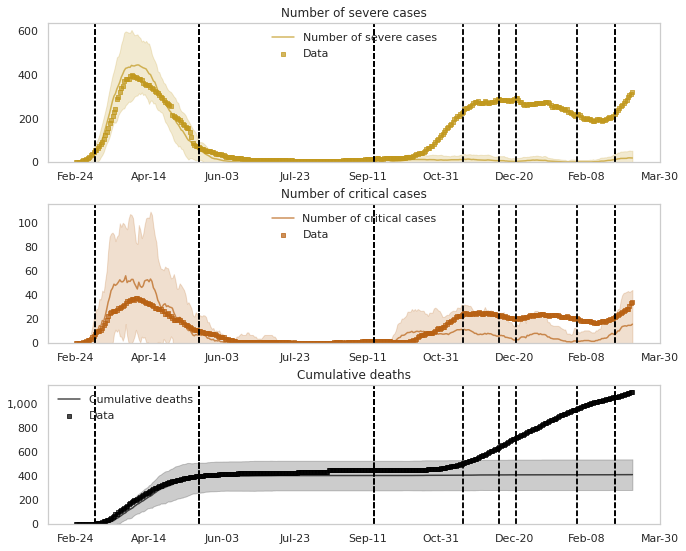

In [7]:
initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
initial_params.update(default_params)

intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
interventions = get_interventions(intervention_params)

sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)

msim.mean()
msim.plot(cols);

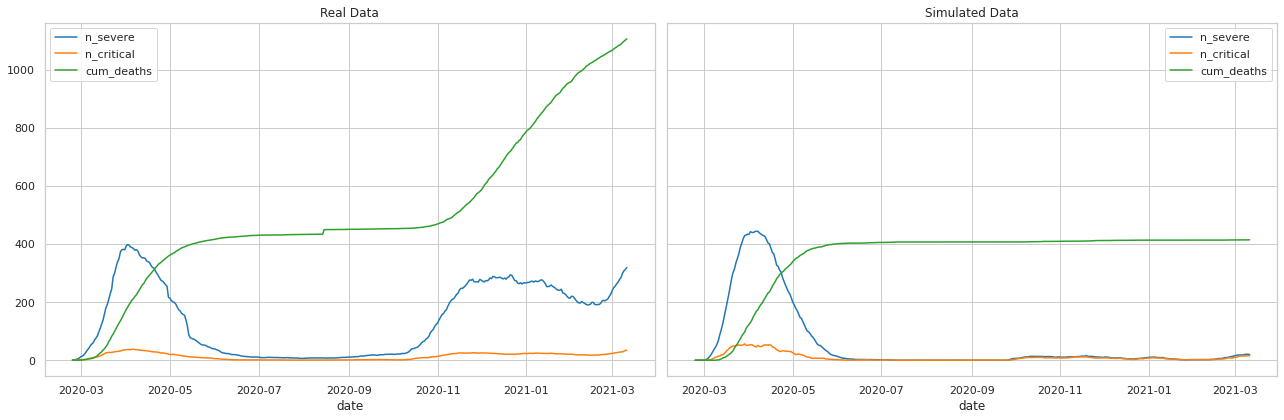

In [8]:
_, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for col in cols:
    sns.lineplot(data=df, x='date', y=col, label=col, ax=axes[0]).set(title='Real Data', ylabel='')
    sns.lineplot(data=msim.results, x='date', y=col, label=col, ax=axes[1]).set(title='Simulated Data', ylabel='')

plt.tight_layout()